# Main Analysis File: 250 ms

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.anova import AnovaRM
import copy
import datetime
import json
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression



## Load data

In [2]:
MX_data = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/data/tx-MX-data-250ms.csv')

len(MX_data.subjID.unique())

324

### Seperate data by condition (objMask, familiar)

In [3]:
oM_data = MX_data[MX_data['stimulus'].str.contains('_BC', na=False)]
fS_data = MX_data[~MX_data['stimulus'].str.contains('_BC', na=False)]

In [4]:
oM_data.condition.unique(), fS_data.condition.unique()

(array(['BC'], dtype=object), array(['FS'], dtype=object))

In [5]:
oM_data.columns

Index(['Unnamed: 0', 'subjID', 'workerId', 'experimentName', 'versionName',
       'sequenceName', 'url', 'selected_row', 'windowWidth', 'windowHeight',
       'screenWidth', 'screenHeight', 'startDate', 'startTime', 'trial',
       'stimulus', 'duration', 'scale', 'actual_depth', 'depth_estimate',
       'trial_RT', 'log_sceneDuration', 'unitSelection', 'seq_filepath',
       'experimentTime', 'totalTime', 'age', 'gender', 'imageName',
       'zs_depth_estimates', 'zs_actual_depth', 'zs_trial_RT', 'condition'],
      dtype='object')

## Functions

In [6]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

def trial_pivotTable(data, col, RT_col):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    #generate pivot tables for data statistics (avg, std, sem)
    actual = pd.pivot_table(data,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
    actual.reset_index()
    actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
    avg = pd.pivot_table(data,  values = [col], columns=['stimulus'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={col: 'Average Estimated Depth'})
        
    RT = pd.pivot_table(data,  values = [RT_col], columns=['stimulus'], aggfunc=np.mean)
    RT.reset_index()
    RT_renamed = RT.rename(index={RT_col: 'Average Trial RT'})
        
    std = pd.pivot_table(data, values = [col], columns = ["stimulus"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={col: 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = [col], columns = ["stimulus"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={col: 'Standard Error'})
        
    RTsem = pd.pivot_table(data, values = [RT_col], columns = ["stimulus"], aggfunc = 'sem')
    RTsem.reset_index()
    RTsem_renamed = RTsem.rename(index={RT_col: 'RT Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed, RT_renamed, RTsem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
    result = result.sort_values(by=['Actual Depth'])

    
    return result

def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [125, 250, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_125, x_250, x_1000]
        xs = [list of individual targets]
        ys = [y_125, y_250, y_1000]
        stes = [ste_125, ste_250, ste_1000]
        
    """
    
    
    x = []
    y = []
    ste = []
    std = []
    actualdepth = []
    RT = []
    RT_stes = []
    for idx, row in data.iterrows():
            
        x.append(idx) #idx is the target (stimulus path)
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
            
        depth = row["Actual Depth"]
        actualdepth.append(depth)
            
        standard_deviation = row["Standard Deviation"]
        std.append(standard_deviation)       
            
        reactionTime = row["Average Trial RT"]
        RT.append(reactionTime)  
            
        reactionTime_ste = row["RT Standard Error"]
        RT_stes.append(reactionTime_ste)  
            

    return x, y, ste, actualdepth, std, RT, RT_stes

## Results

In [7]:
pivotTable = trial_pivotTable(MX_data, 'zs_depth_estimates', 'zs_trial_RT')
trial_final = trial_getxy(pivotTable)

results_250 = {}

results_250['stimuli'] = trial_final[0]
results_250['y'] = trial_final[1]
results_250['ste'] = trial_final[2]
results_250['x'] = trial_final[3]
results_250['std'] = trial_final[4]
results_250['RT'] = trial_final[5]
results_250['RT_ste'] = trial_final[6]

results_250['actual_depth'] = (np.array(results_250['x']) - np.mean(np.array(results_250['x'])))/np.std(np.array(results_250['x']))

In [8]:
from scipy.stats import pearsonr
pearsonr(results_250['actual_depth'], results_250['y'])

(0.8547580821953848, 1.014840167297566e-93)

Text(0.5, 1.0, '250ms')

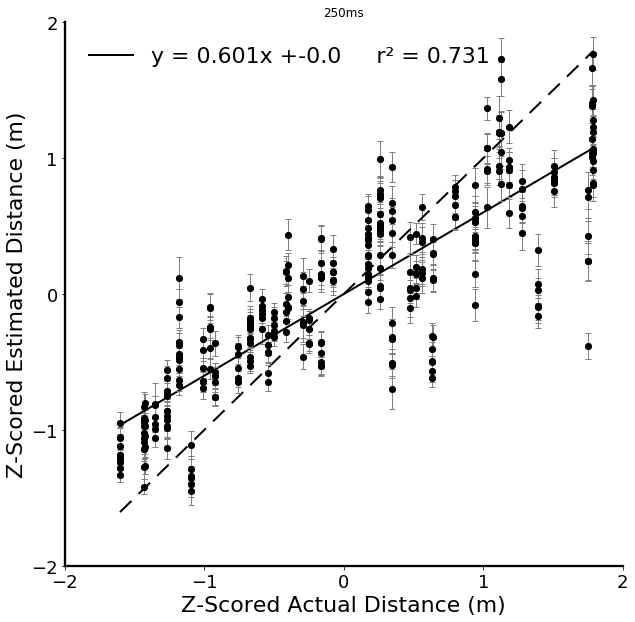

In [10]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(results_250['actual_depth']).reshape(-1,1)
y = results_250['y']
ste = results_250['ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='black', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "black", mec = "black", capsize = 3)

plt.ylim(-2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 1), fontsize=18)


legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

plt.title('250ms')

In [10]:
fig_destination = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/figures-presentations/figs/250'

### Familiar

In [11]:
len(fS_data_sm[col]), len(fS_data_can[col]), len(fS_data_lg[col])


len(fS_data_sm[col]) + len(fS_data_can[col]) - 2, len(fS_data_lg[col]) + len(fS_data_can[col]) -2

NameError: name 'fS_data_sm' is not defined

64.94022923722274 1.0238095448626606e-28
20.759444630284815 5.316813711582208e-06
128.06182848577888 2.2467787997013345e-29
46.71599879999989 9.065546737036114e-12


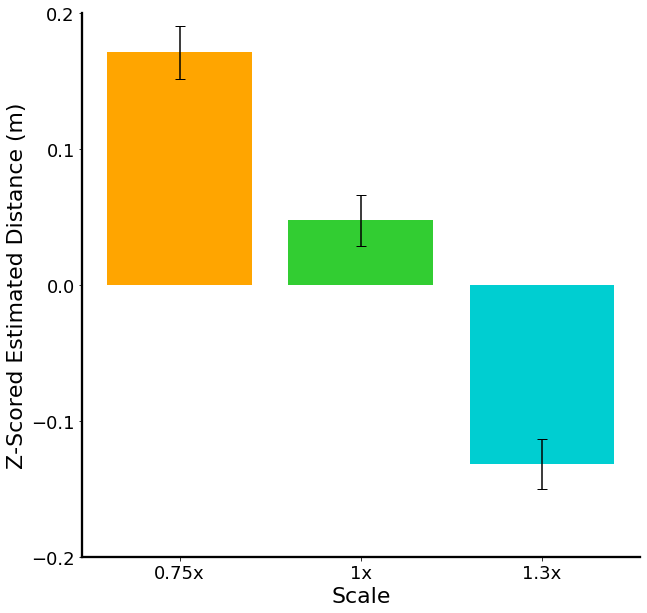

In [12]:
fS_data_sm = fS_data.loc[fS_data['scale']=='0.75x']
fS_data_can = fS_data.loc[fS_data['scale']=='1x']
fS_data_lg = fS_data.loc[fS_data['scale']=='1.3x']

# set whether analyzing raw data or zscored data

# col = 'depth_estimate'
col = 'zs_depth_estimates'


fS_avg_sm = fS_data_sm[col].mean()
fS_avg_can = fS_data_can[col].mean()
fS_avg_lg = fS_data_lg[col].mean()

fS_ste_sm = stats.sem(np.array(fS_data_sm[col]))
fS_ste_can = stats.sem(np.array(fS_data_can[col]))
fS_ste_lg = stats.sem(np.array(fS_data_lg[col]))

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(fS_data_sm[col], fS_data_can[col], fS_data_lg[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(fS_data_sm[col], fS_data_can[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(fS_data_sm[col], fS_data_lg[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(fS_data_can[col], fS_data_lg[col])
print(fvalue, pvalue)

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
scales = ['0.75x', '1x', '1.3x']
fS_averages = [fS_avg_sm, fS_avg_can, fS_avg_lg]
fS_sem = [fS_ste_sm, fS_ste_can, fS_ste_lg]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.ylabel("Estimated Distance (m)", fontsize = 22)

    
plt.yticks(np.arange(-0.20,0.25, 0.1))
plt.ylim(-0.2, 0.20)

plt.bar(scales, fS_averages, yerr = fS_sem, color = ['orange', 'limegreen', 'darkturquoise'], width=0.8, capsize=5)

# plt.title('Familiar', fontsize=25)

# Export the figure at a high resolution
plt.savefig(fig_destination + '/fS-250-avgEstims.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()


### Obj Mask

In [13]:
len(oM_data_sm[col]), len(oM_data_can[col]), len(oM_data_lg[col])


len(oM_data_sm[col]) + len(oM_data_can[col]) - 2, len(oM_data_lg[col]) + len(oM_data_can[col]) -2

NameError: name 'oM_data_sm' is not defined

31.066803348861438 3.6023846554392703e-14
14.456479430705242 0.00014493196784849422
61.77255357343956 4.575165860519802e-15
16.771916839738473 4.273576787477057e-05


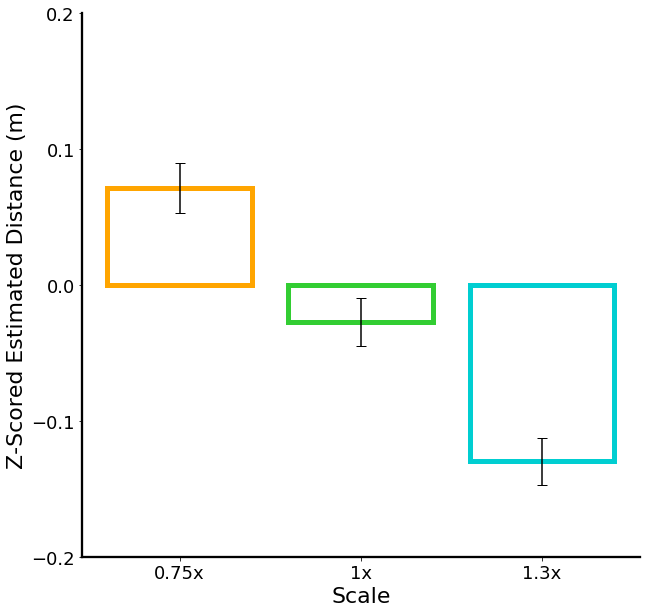

In [14]:
oM_data_sm = oM_data.loc[oM_data['scale']=='0.75x']
oM_data_can = oM_data.loc[oM_data['scale']=='1x']
oM_data_lg = oM_data.loc[oM_data['scale']=='1.3x']

# set whether analyzing raw data or zscored data


oM_avg_sm = oM_data_sm[col].mean()
oM_avg_can = oM_data_can[col].mean()
oM_avg_lg = oM_data_lg[col].mean()

oM_ste_sm = stats.sem(np.array(oM_data_sm[col]))
oM_ste_can = stats.sem(np.array(oM_data_can[col]))
oM_ste_lg = stats.sem(np.array(oM_data_lg[col]))

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(oM_data_sm[col], oM_data_can[col], oM_data_lg[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(oM_data_sm[col], oM_data_can[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(oM_data_sm[col], oM_data_lg[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(oM_data_can[col], oM_data_lg[col])
print(fvalue, pvalue)

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
scales = ['0.75x', '1x', '1.3x']
oM_averages = [oM_avg_sm, oM_avg_can, oM_avg_lg]
oM_sem = [oM_ste_sm, oM_ste_can, oM_ste_lg]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.ylabel("Estimated Distance (m)", fontsize = 22)

    
plt.yticks(np.arange(-0.20,0.25, 0.1))
plt.ylim(-0.2, 0.20)

colors= ['orange', 'limegreen', 'darkturquoise']
plt.bar(scales, oM_averages, yerr=oM_sem, edgecolor=colors, fill=False, linewidth=5, width=0.8, capsize=5)


# plt.title('Object Mask', fontsize=25)

# Export the figure at a high resolution
plt.savefig(fig_destination + '/oM-250-avgEstims.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

41.860034010668926 5.394826791265044e-43
13.577248145519558 0.00023107704867895
8.266666537120948 0.004052943404966807
0.0054711241885654835 0.9410392048763306


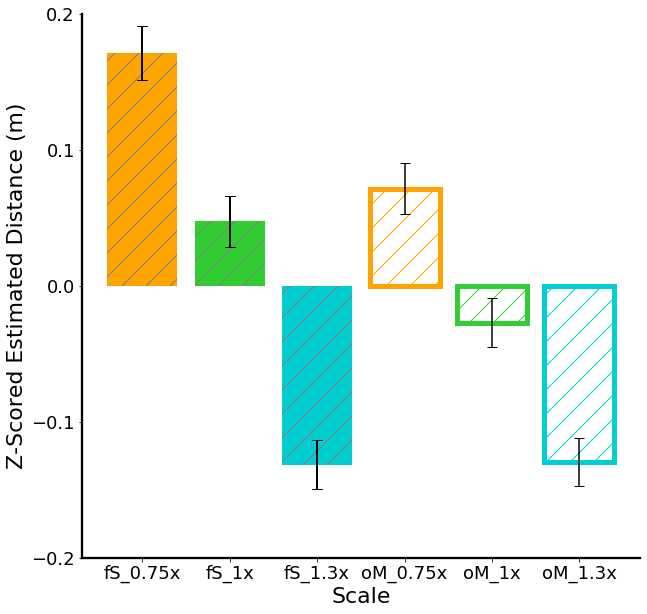

In [18]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(fS_data_sm[col], fS_data_can[col], fS_data_lg[col], oM_data_sm[col], oM_data_can[col], oM_data_lg[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(fS_data_sm[col], oM_data_sm[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(fS_data_can[col], oM_data_can[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(fS_data_lg[col], oM_data_lg[col])
print(fvalue, pvalue)


fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
scales_ = ['fS_0.75x', 'fS_1x','fS_1.3x', 'oM_0.75x', 'oM_1x', 'oM_1.3x']


averages = [fS_avg_sm, fS_avg_can, fS_avg_lg, oM_avg_sm, oM_avg_can, oM_avg_lg]

sem = [fS_ste_sm, fS_ste_can, fS_ste_lg, oM_ste_sm, oM_ste_can, oM_ste_lg]


plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.ylabel("Estimated Distance (m)", fontsize = 22)

    
plt.yticks(np.arange(-0.20,0.25, 0.1))
plt.ylim(-0.2, 0.20)

# Colors for the bars
colors = ['orange', 'limegreen', 'darkturquoise', 'orange', 'limegreen', 'darkturquoise']

# Plot the bars with solid fill colors
plt.bar(scales_[:3], averages[:3], yerr=sem[:3], color=colors[:3], width=0.8, capsize=5)

# Overlay transparent bars with gray hatches
plt.bar(scales_[:3], averages[:3], yerr=sem[:3], color=colors[:3], width=0.8, capsize=5)
plt.bar(scales_[:3], averages[:3], yerr=sem[:3], edgecolor='gray', fill=False, linewidth=0.1, width=0.8, capsize=5, hatch='/')

# Plot the last three bars with colored outline, no fill
plt.bar(scales_[3:], averages[3:], yerr=sem[3:], edgecolor=colors[3:], fill=False, linewidth=5, width=0.8, capsize=5, hatch='/')

# plt.title('', fontsize=25)

# Export the figure at a high resolution
plt.savefig(fig_destination + '/250-avgEstims.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

#### Plot the main effect of condition

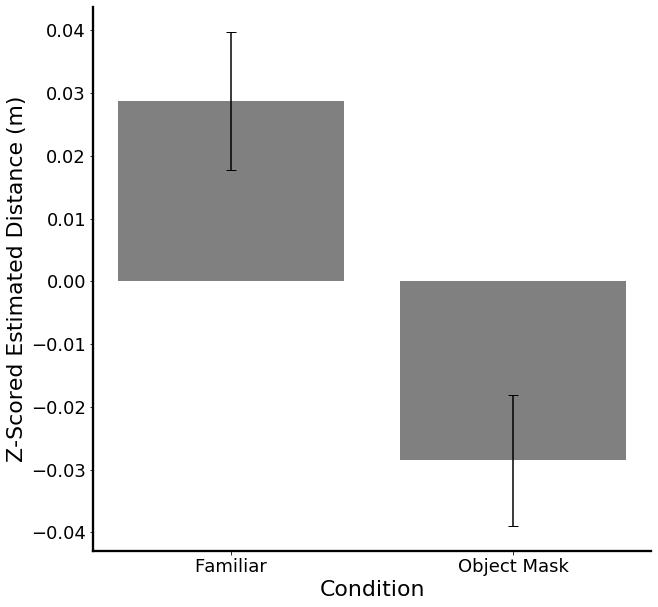

In [12]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
conditions = ['Familiar', 'Object Mask']
averages = [fS_data[col].mean(), oM_data[col].mean()]
sem = [stats.sem(np.array(fS_data[col])), stats.sem(np.array(oM_data[col]))]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Condition", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.ylabel("Estimated Distance (m)", fontsize = 22)

    
# plt.yticks(np.arange(-0.20,0.25, 0.05))

plt.bar(conditions, averages, yerr = sem, color = ['gray', 'gray'], width=0.8, capsize=5)

plt.show();


### Repeated Measures ANOVA

In [13]:
def rm_ANOVA_data(df, col):
    data = {'Subject': [], 'Scale': [], 'Condition': [], 'Avg_Estim': []}
    for subj in df.subjID.unique():
        subj_df = df.loc[df['subjID']==subj]
        scales = ['0.75x', '1x', '1.3x']
        conditions = ['BC', 'FS']
        for scale in scales:
            scale_df = subj_df.loc[subj_df['scale']==scale]
            for cond in conditions:
                scale_cond_df = scale_df.loc[scale_df['condition']==cond]
                avg_scale_cond = scale_cond_df[col].mean()
                data['Subject'].append(subj)
                data['Scale'].append(scale)
                data['Condition'].append(cond)
                data['Avg_Estim'].append(avg_scale_cond)
                # .75BC, .75FS, 1BC, 1FS... 
                # print(scale, cond)


    return data 

In [14]:
subject_data = rm_ANOVA_data(MX_data, col)
subject_data_df = pd.DataFrame(subject_data)

In [15]:
# subject_data

In [16]:
from statsmodels.stats.anova import AnovaRM

# Perform the repeated measures ANOVA
aovrm = AnovaRM(subject_data_df, 'Avg_Estim', 'Subject', within=['Condition', 'Scale'])
res = aovrm.fit()

print(res)

                     Anova
                F Value  Num DF  Den DF  Pr > F
-----------------------------------------------
Condition        12.2279 1.0000 323.0000 0.0005
Scale           113.9216 2.0000 646.0000 0.0000
Condition:Scale   3.3946 2.0000 646.0000 0.0342



### Difference between scale conditions by subject


In [17]:
def subj_diffs(df):
    diffs_1x_75x = []
    diffs_13x_1x = []
    for subj in df.subjID.unique():
        subj_df = df.loc[df['subjID']==subj]
        conditions = {'0.75x': None, '1x': None, '1.3x': None}
        for cond in conditions.keys():
            cond_df = subj_df.loc[subj_df['scale']== cond]
            avg_estim_cond = cond_df['depth_estimate'].mean()
            conditions[cond] = avg_estim_cond

        diffs_1x_75x.append(conditions['1x']-conditions['0.75x'])
        diffs_13x_1x.append(conditions['1x']-conditions['1.3x'])

    return diffs_1x_75x, diffs_13x_1x
                

In [18]:
fS_diffs_1x_75x, fS_diffs_1x_13x = subj_diffs(fS_data)
oM_diffs_1x_75x, oM_diffs_1x_13x = subj_diffs(oM_data)

8.713470550216726 0.003273236272093209


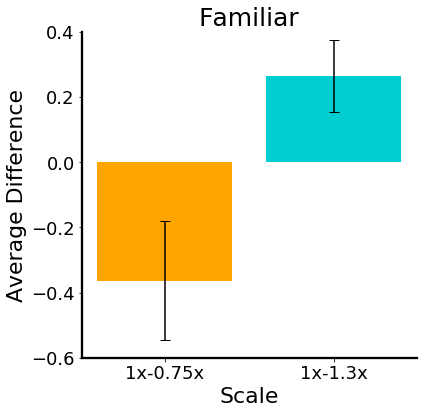

In [19]:
fig, ax = plt.subplots(figsize=[6,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

fvalue, pvalue = stats.f_oneway((np.array(fS_diffs_1x_75x)), np.array(fS_diffs_1x_13x))
print(fvalue, pvalue)


diffs = ['1x-0.75x', '1x-1.3x']

# the difference between in each scale condition is calculated BY SUBJECT
# the average of those differences is then calculated and plotted below
fS_diffs_averages = [np.mean(np.array(fS_diffs_1x_75x)), np.mean(np.array(fS_diffs_1x_13x))]
fS_diffs_sem = [stats.sem(np.array(fS_diffs_1x_75x)), stats.sem(np.array(fS_diffs_1x_13x))]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Average Difference", fontsize = 22)

else:
    plt.ylabel("Average Difference (raw)", fontsize = 22)

plt.ylim(-.6, 0.4)
plt.yticks(np.arange(-.6,.6, 0.2))

plt.bar(diffs, fS_diffs_averages, yerr = fS_diffs_sem, color = ['orange', 'darkturquoise'], width=0.8, capsize=5)

plt.title('Familiar', fontsize=25)
plt.show()



-50.55555555555556 15.888888888888886


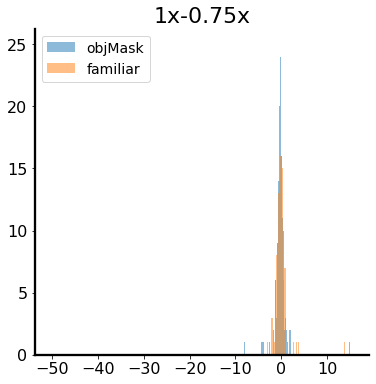

In [20]:
fig, ax = plt.subplots(figsize=[6,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

# Determine the global min and max
global_min = min(min(oM_diffs_1x_75x), min(fS_diffs_1x_75x))
global_max = max(max(oM_diffs_1x_75x), max(fS_diffs_1x_75x))
print(global_min, global_max)

# Choose a bin width
bin_width = .1  # Adjust this value as needed for your data

# Create bins
bins = np.arange(global_min, global_max + bin_width, bin_width)

plt.title('1x-0.75x', fontsize=22)
plt.hist(oM_diffs_1x_75x, bins=bins, label='objMask', alpha=0.5)
plt.hist(fS_diffs_1x_75x, bins=bins, label='familiar', alpha=0.5)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=14)
plt.show()

In [21]:
# fig, ax = plt.subplots(figsize=[6,6])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(2.3)

# # Determine the global min and max
# global_min = min(min(oM_diffs_13x_1x), min(fs_diffs_13x_1x))
# global_max = max(max(oM_diffs_13x_1x), max(fs_diffs_13x_1x))
# print(global_min, global_max)

# # Choose a bin width
# bin_width = .1  # Adjust this value as needed for your data

# # Create bins
# bins = np.arange(global_min, global_max + bin_width, bin_width)

# plt.title('13x-1x', fontsize=22)
# plt.hist(oM_diffs_13x_1x, bins=bins, label='objMask', alpha=0.5)
# plt.hist(fs_diffs_13x_1x, bins=bins, label='familiar', alpha=0.5)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

# plt.legend(fontsize=14)
# plt.show()

6.2853322500676825 0.012418512461935578


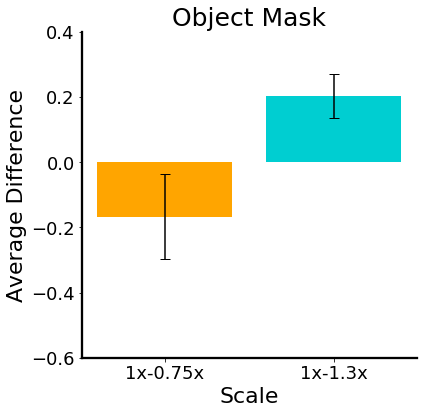

In [22]:
fig, ax = plt.subplots(figsize=[6,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

fvalue, pvalue = stats.f_oneway((np.array(oM_diffs_1x_75x)), np.array(oM_diffs_1x_13x))
print(fvalue, pvalue)


diffs = ['1x-0.75x', '1x-1.3x']

# the difference between in each scale condition is calculated BY SUBJECT
# the average of those differences is then calculated and plotted below
oM_diffs_averages = [np.mean(np.array(oM_diffs_1x_75x)), np.mean(np.array(oM_diffs_1x_13x))]
oM_diffs_sem = [stats.sem(np.array(oM_diffs_1x_75x)), stats.sem(np.array(oM_diffs_1x_13x))]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Average Difference", fontsize = 22)

else:
    plt.ylabel("Average Difference (raw)", fontsize = 22)

    
plt.ylim(-.6, 0.4)
plt.yticks(np.arange(-.6,.6, 0.2))

plt.bar(diffs, oM_diffs_averages, yerr = oM_diffs_sem, color = ['orange', 'darkturquoise'], width=0.8, capsize=5)

plt.title('Object Mask', fontsize=25)
plt.show()

5.375585692132261 0.0011163842045613965
0.7738121357177922 0.37936742145654256
0.2224549713612457 0.6373349418598129


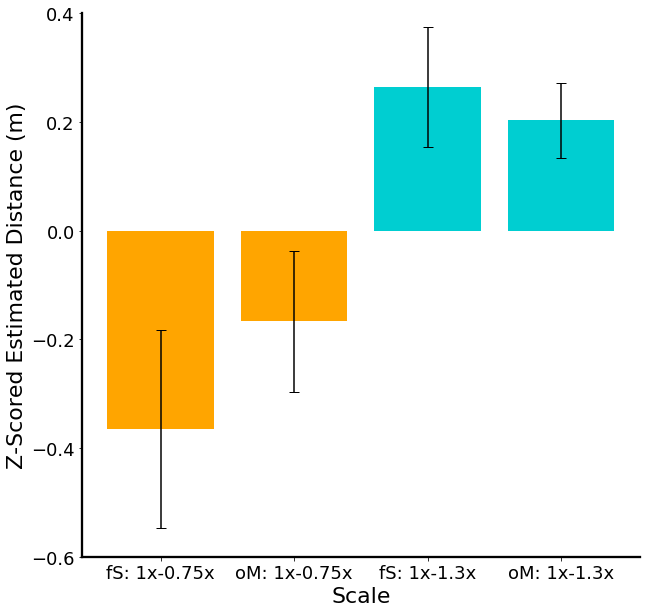

In [23]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

fvalue, pvalue = stats.f_oneway((np.array(fS_diffs_1x_75x)), np.array(fS_diffs_1x_13x), (np.array(oM_diffs_1x_75x)), np.array(oM_diffs_1x_13x))
print(fvalue, pvalue)
fvalue, pvalue = stats.f_oneway((np.array(fS_diffs_1x_75x)), (np.array(oM_diffs_1x_75x)))
print(fvalue, pvalue)
fvalue, pvalue = stats.f_oneway((np.array(fS_diffs_1x_13x)), (np.array(oM_diffs_1x_13x)))
print(fvalue, pvalue)
    
diffs = ['fS: 1x-0.75x', 'oM: 1x-0.75x', 'fS: 1x-1.3x', 'oM: 1x-1.3x']
all_avg_diffs = [np.mean(np.array(fS_diffs_1x_75x)), np.mean(np.array(oM_diffs_1x_75x)), np.mean(np.array(fS_diffs_1x_13x)), np.mean(np.array(oM_diffs_1x_13x))]
sem = [stats.sem(np.array(fS_diffs_1x_75x)), stats.sem(np.array(oM_diffs_1x_75x)), stats.sem(np.array(fS_diffs_1x_13x)), stats.sem(np.array(oM_diffs_1x_13x))]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.ylabel("Estimated Distance (m)", fontsize = 22)

    
plt.ylim(-.6, 0.4)
plt.yticks(np.arange(-.6,.6, 0.2))

plt.bar(diffs, all_avg_diffs, yerr = sem, color = ['orange', 'orange', 'darkturquoise', 'darkturquoise'], width=0.8, capsize=5)

plt.title('', fontsize=25)
plt.show()

## Normalize by 1x responses

In [24]:
def norm_by_1x(row, avg, col):
    return row[col] / avg

def subj_normalize(df, col):
    subj_1x_avg = df.loc[df['scale'] == '1x', col].mean()
    df[f'normed_{col}'] = df.apply(norm_by_1x, axis=1, args=(subj_1x_avg, col))
    return df

def main_subj_normalized(df, col):
    data = [subj_normalize(df.loc[df['subjID'] == subj], col) for subj in df['subjID'].unique()]
    return pd.concat(data, ignore_index=True)

def main_normalized(df, col):

    _1x_avg = df.loc[df['scale'] == '1x', col].mean()        
    print(_1x_avg)
    df[f'normed_{col}'] = df.apply(norm_by_1x, axis=1, args=(abs(_1x_avg), col))

    return df

In [25]:
MX_data.condition.unique()

array(['FS', 'BC'], dtype=object)

In [26]:
# normalized by the average 1x estimate within each condition
# normed_fS_data = main_normalized(fS_data, col)
# normed_oM_data = main_normalized(oM_data, col)

# normalized by each subjects average 1x estimate within each condition 
# normed_fS_data = main_subj_normalized(fS_data, col)
# normed_oM_data = main_subj_normalized(oM_data, col)

# normalized by the average 1x estimate between conditions 
normed_fS_data = main_normalized(fS_data, col)
normed_oM_data = main_normalized(oM_data, col)

0.04747694766696846
-0.027262359688302124


/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


64.94022923722274 1.0238095448626606e-28
20.759444630284808 5.316813711582208e-06
128.0618284857789 2.2467787997013345e-29
46.71599879999991 9.065546737036114e-12


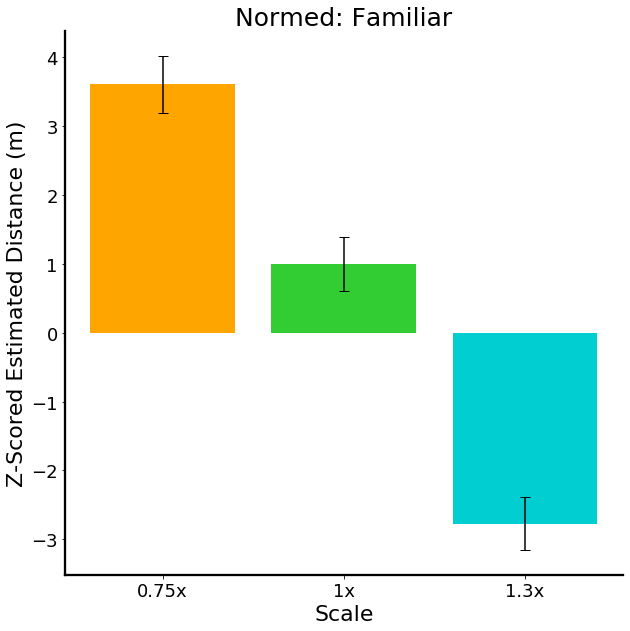

In [27]:
n_fS_data_sm = normed_fS_data.loc[normed_fS_data['scale']=='0.75x']
n_fS_data_can = normed_fS_data.loc[normed_fS_data['scale']=='1x']
n_fS_data_lg = normed_fS_data.loc[normed_fS_data['scale']=='1.3x']

n_col = 'normed_' + col

n_fS_avg_sm = n_fS_data_sm[n_col].mean()
n_fS_avg_can = n_fS_data_can[n_col].mean()
n_fS_avg_lg = n_fS_data_lg[n_col].mean()

n_fS_ste_sm = stats.sem(np.array(n_fS_data_sm[n_col]))
n_fS_ste_can = stats.sem(np.array(n_fS_data_can[n_col]))
n_fS_ste_lg = stats.sem(np.array(n_fS_data_lg[n_col]))

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(n_fS_data_sm[n_col], n_fS_data_can[n_col], n_fS_data_lg[n_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_fS_data_sm[n_col], n_fS_data_can[n_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_fS_data_sm[n_col], n_fS_data_lg[n_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_fS_data_can[n_col], n_fS_data_lg[n_col])
print(fvalue, pvalue)

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
scales = ['0.75x', '1x', '1.3x']
n_fS_averages = [n_fS_avg_sm, n_fS_avg_can, n_fS_avg_lg]
n_fS_sem = [n_fS_ste_sm, n_fS_ste_can, n_fS_ste_lg]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.ylabel("Estimated Distance (m)", fontsize = 22)

    
# plt.yticks(np.arange(-0.20,0.25, 0.05))

plt.bar(scales, n_fS_averages, yerr = n_fS_sem, color = ['orange', 'limegreen', 'darkturquoise'], width=0.8, capsize=5)

plt.title('Normed: Familiar', fontsize=25)
plt.show()

31.066803348861438 3.6023846554392703e-14
14.793885651873245 0.00012123063775607273
61.77255357343958 4.575165860519802e-15


16.77191683973847 4.273576787477057e-05


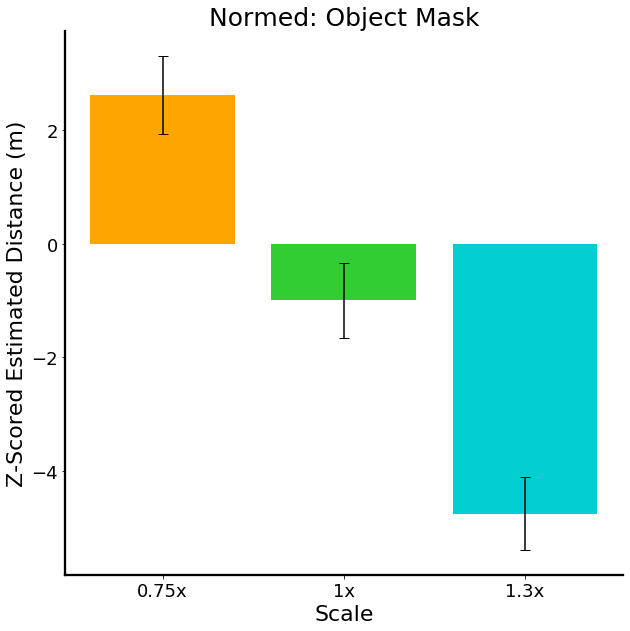

In [28]:
n_oM_data_sm = normed_oM_data.loc[normed_oM_data['scale']=='0.75x']
n_oM_data_can = normed_oM_data.loc[normed_oM_data['scale']=='1x']
n_oM_data_lg = normed_oM_data.loc[normed_oM_data['scale']=='1.3x']


n_oM_avg_sm = n_oM_data_sm[n_col].mean()
n_oM_avg_can = n_oM_data_can[n_col].mean()
n_oM_avg_lg = n_oM_data_lg[n_col].mean()

n_oM_ste_sm = stats.sem(np.array(n_oM_data_sm[n_col]))
n_oM_ste_can = stats.sem(np.array(n_oM_data_can[n_col]))
n_oM_ste_lg = stats.sem(np.array(n_oM_data_lg[n_col]))

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(n_oM_data_sm[n_col], n_oM_data_can[n_col], n_oM_data_lg[n_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_oM_data_sm[n_col], n_oM_data_can[col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_oM_data_sm[n_col], n_oM_data_lg[n_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_oM_data_can[n_col], n_oM_data_lg[n_col])
print(fvalue, pvalue)

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
scales = ['0.75x', '1x', '1.3x']
n_oM_averages = [n_oM_avg_sm, n_oM_avg_can, n_oM_avg_lg]
n_oM_sem = [n_oM_ste_sm, n_oM_ste_can, n_oM_ste_lg]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.ylabel("Estimated Distance (m)", fontsize = 22)

    
# plt.yticks(np.arange(-0.20,0.25, 0.05))

plt.bar(scales, n_oM_averages, yerr = n_oM_sem, color = ['orange', 'limegreen', 'darkturquoise'], width=0.8, capsize=5)

plt.title('Normed: Object Mask', fontsize=25)
plt.show()

34.68326946338068 2.0783464382490122e-35
1.5116691630737296 0.2189355352382516
6.762924902925965 0.009331182283773895
7.074065516995264 0.00784267630284269


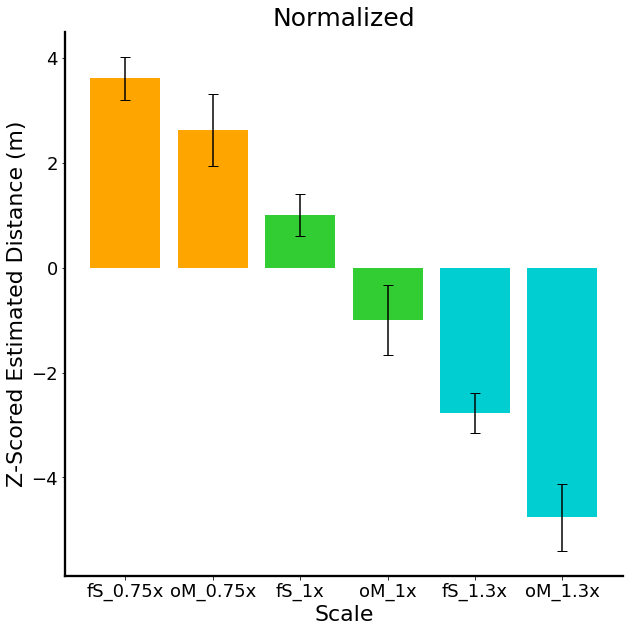

In [29]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(n_fS_data_sm[n_col], n_fS_data_can[n_col], n_fS_data_lg[n_col], n_oM_data_sm[n_col], n_oM_data_can[n_col], n_oM_data_lg[n_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_fS_data_sm[n_col], n_oM_data_sm[n_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_fS_data_can[n_col], n_oM_data_can[n_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_fS_data_lg[n_col], n_oM_data_lg[n_col])
print(fvalue, pvalue)


fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
scales_ = ['fS_0.75x', 'oM_0.75x', 'fS_1x', 'oM_1x', 'fS_1.3x','oM_1.3x']
n_averages = [n_fS_avg_sm, n_oM_avg_sm, n_fS_avg_can, n_oM_avg_can, n_fS_avg_lg, n_oM_avg_lg]
n_sem = [n_fS_ste_sm, n_oM_ste_sm, n_fS_ste_can, n_oM_ste_can, n_fS_ste_lg, n_oM_ste_lg]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
if col == 'zs_depth_estimates':
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.ylabel("Estimated Distance (m)", fontsize = 22)

    
# plt.yticks(np.arange(-0.20,0.25, 0.05))

plt.bar(scales_, n_averages, yerr = n_sem, color = ['orange', 'orange', 'limegreen', 'limegreen', 'darkturquoise', 'darkturquoise'], width=0.8, capsize=5)

plt.title('Normalized', fontsize=25)
plt.show()

## By scene analysis

In [30]:
def scene_analysis(df):
    diffs_1x_75x = []
    diffs_13x_1x = []
    for img in df.imageName.unique():
        img_df = df.loc[df['imageName']==img]
        conditions = {'0.75x': None, '1x': None, '1.3x': None}
        for cond in conditions.keys():
            cond_df = img_df.loc[img_df['scale']== cond]
            avg_estim_cond = cond_df['depth_estimate'].mean()
            conditions[cond] = avg_estim_cond

        diffs_1x_75x.append(conditions['1x']-conditions['0.75x'])
        diffs_13x_1x.append(conditions['1.3x']-conditions['1x'])

    return diffs_1x_75x, diffs_13x_1x

In [31]:
fs_diffs_byScene_1x_75x, fs_diffs_byScene_13x_1x = scene_analysis(fS_data)
oM_diffs_byScene_1x_75x, oM_diffs_byScene_13x_1x = scene_analysis(oM_data)

In [32]:
len(fs_diffs_byScene_1x_75x), len(oM_diffs_byScene_1x_75x)

(54, 54)

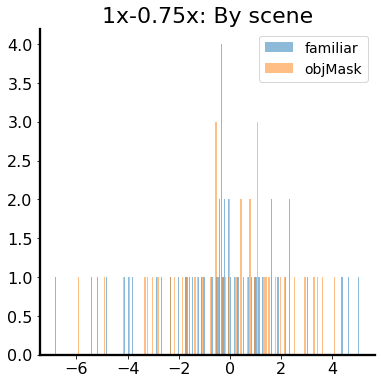

Average difference: familiar, object mask
-0.18990571246410107 -0.16417766093013078


In [33]:
fig, ax = plt.subplots(figsize=[6,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

# Determine the global min and max
global_min = min(min(oM_diffs_byScene_1x_75x), min(fs_diffs_byScene_1x_75x))
global_max = max(max(oM_diffs_byScene_1x_75x), max(fs_diffs_byScene_1x_75x))
# print(global_min, global_max)

# Choose a bin width
bin_width = .05  # Adjust this value as needed for your data

# Create bins
bins = np.arange(global_min, global_max + bin_width, bin_width)

plt.title('1x-0.75x: By scene', fontsize=22)
plt.hist(fs_diffs_byScene_1x_75x, bins=bins, label='familiar', alpha=0.5)
plt.hist(oM_diffs_byScene_1x_75x, bins=bins, label='objMask', alpha=0.5)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=14)
plt.show()

print('Average difference: familiar, object mask')
print(np.mean(np.array(fs_diffs_byScene_13x_1x)), np.mean(np.array(oM_diffs_byScene_13x_1x)))

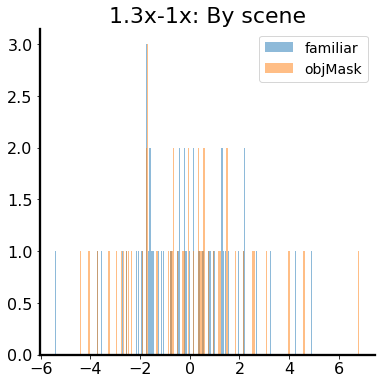

Average difference: familiar, object mask
-0.18990571246410107 -0.16417766093013078


In [34]:
fig, ax = plt.subplots(figsize=[6,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

# Determine the global min and max
global_min = min(min(oM_diffs_byScene_13x_1x), min(fs_diffs_byScene_13x_1x))
global_max = max(max(oM_diffs_byScene_13x_1x), max(fs_diffs_byScene_13x_1x))
# print(global_min, global_max)

# Choose a bin width
bin_width = .05  # Adjust this value as needed for your data

# Create bins
bins = np.arange(global_min, global_max + bin_width, bin_width)


plt.title('1.3x-1x: By scene', fontsize=22)
plt.hist(fs_diffs_byScene_13x_1x, bins=bins, label='familiar', alpha=0.5)
plt.hist(oM_diffs_byScene_13x_1x, bins=bins, label='objMask', alpha=0.5)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=14)
plt.show()

print('Average difference: familiar, object mask')
print(np.mean(np.array(fs_diffs_byScene_13x_1x)), np.mean(np.array(oM_diffs_byScene_13x_1x)))

## Familiar x Object Mask

In [35]:
def get_target_results(df, col,RT_col):
    df_75x = df.loc[df['scale']=='0.75x']
    df_1x = df.loc[df['scale']=='1x']
    df_13x = df.loc[df['scale']=='1.3x']

    trial_pivot_75x = trial_pivotTable(df_75x, col, RT_col)
    trial_pivot_1x = trial_pivotTable(df_1x, col, RT_col)
    trial_pivot_13x = trial_pivotTable(df_13x, col, RT_col)

    trial_final_75x = trial_getxy(trial_pivot_75x)
    trial_final_1x = trial_getxy(trial_pivot_1x)
    trial_final_13x = trial_getxy(trial_pivot_13x)

    results_75x = {}

    results_75x['stimuli'] = trial_final_75x[0]
    results_75x['y'] = trial_final_75x[1]
    results_75x['ste'] = trial_final_75x[2]
    results_75x['x'] = trial_final_75x[3]
    results_75x['std'] = trial_final_75x[4]
    results_75x['RT'] = trial_final_75x[5]
    results_75x['RT_ste'] = trial_final_75x[6]

    # Z-Score Actual Depth 
    if col == 'zs_depth_estimates':
        results_75x['actual_depth'] = (np.array(results_75x['x']) - np.mean(np.array(results_75x['x'])))/np.std(np.array(results_75x['x']))
    else:
        results_75x['actual_depth'] = np.array(results_75x['x'])

    results_1x = {}

    results_1x['stimuli'] = trial_final_1x[0]
    results_1x['y'] = trial_final_1x[1]
    results_1x['ste'] = trial_final_1x[2]
    results_1x['x'] = trial_final_1x[3]
    results_1x['std'] = trial_final_1x[4]
    results_1x['RT'] = trial_final_1x[5]
    results_1x['RT_ste'] = trial_final_1x[6]

    # Z-Score Actual Depth 
    if col == 'zs_depth_estimates':
        results_1x['actual_depth'] = (np.array(results_1x['x']) - np.mean(np.array(results_1x['x'])))/np.std(np.array(results_1x['x']))
    else:
        results_1x['actual_depth'] = np.array(results_1x['x'])

    results_13x = {}

    results_13x['stimuli'] = trial_final_13x[0]
    results_13x['y'] = trial_final_13x[1]
    results_13x['ste'] = trial_final_13x[2]
    results_13x['x'] = trial_final_13x[3]
    results_13x['std'] = trial_final_13x[4]
    results_13x['RT'] = trial_final_13x[5]
    results_13x['RT_ste'] = trial_final_13x[6]

    # Z-Score Actual Depth 
    if col == 'zs_depth_estimates':
        results_13x['actual_depth'] = (np.array(results_13x['x']) - np.mean(np.array(results_13x['x'])))/np.std(np.array(results_13x['x']))
    else:
        results_13x['actual_depth'] = np.array(results_13x['x'])

    return results_75x, results_1x, results_13x

    

In [36]:
fS_results_75x, fS_results_1x, fS_results_13x = get_target_results(fS_data, col, 'zs_trial_RT')
oM_results_75x, oM_results_1x, oM_results_13x = get_target_results(oM_data, col, 'zs_trial_RT')

### Run each regression and save to result dictionary
##### Familiar

In [60]:
pearsonr(fS_results_75x['actual_depth'], fS_results_75x['y'])

(0.8611334246645019, 6.695380420984045e-17)

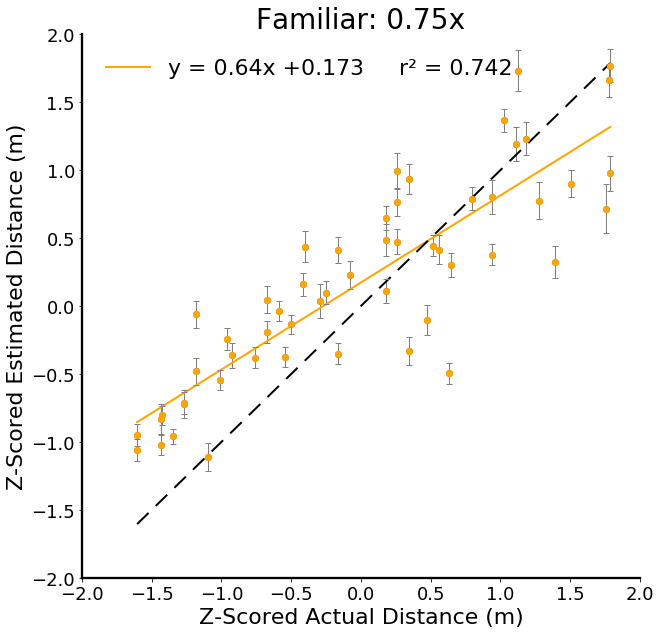

In [37]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(fS_results_75x['actual_depth']).reshape(-1,1)
y = fS_results_75x['y']
ste = fS_results_75x['ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Familiar: 0.75x", fontsize = 28)

if col == 'zs_depth_estimates':
    plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.xlabel("Actual Distance (m)", fontsize = 22)
    plt.ylabel("Estimated Distance (m)", fontsize = 22)


dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "orange", mec = "orange", capsize = 3)

if col == 'zs_depth_estimates':
    plt.ylim(-2,2)
    plt.xlim(-2,2)

    plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
    plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)
else:
    plt.xticks(fontsize=18)
    plt.ylim(0, 9)
    plt.yticks(np.arange(0, 9, 1), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


# Save results to a dictionary
fS_results_75x['intercept'] = reg.intercept_
fS_results_75x['slope'] = reg.coef_[0]
fS_results_75x['r2'] = r2_score(y, y_predicted)
fS_results_75x['residuals'] = copy.deepcopy(y - y_predicted)

In [61]:
pearsonr(fS_results_1x['actual_depth'], fS_results_1x['y'])

(0.85239776128278, 2.9223870843574713e-16)

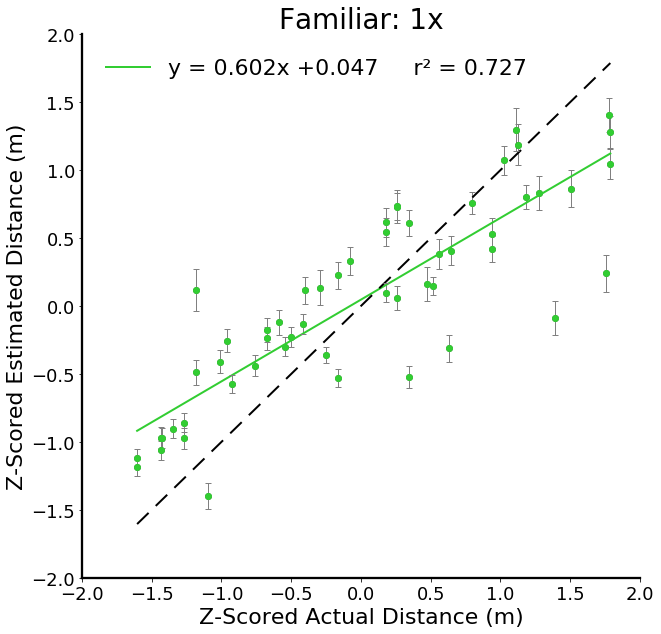

In [38]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

X = np.array(fS_results_1x['actual_depth']).reshape(-1,1)
y = fS_results_1x['y']
ste = fS_results_1x['ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Familiar: 1x", fontsize = 28)

if col == 'zs_depth_estimates':
    plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.xlabel("Actual Distance (m)", fontsize = 22)
    plt.ylabel("Estimated Distance (m)", fontsize = 22)


dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "limegreen", mec = "limegreen", capsize = 3)

if col == 'zs_depth_estimates':
    plt.ylim(-2,2)
    plt.xlim(-2,2)

    plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
    plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)
else:
    plt.xticks(fontsize=18)
    plt.ylim(0, 9)
    plt.yticks(np.arange(0, 9, 1), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


# Save results to a dictionary
fS_results_1x['intercept'] = reg.intercept_
fS_results_1x['slope'] = reg.coef_[0]
fS_results_1x['r2'] = r2_score(y, y_predicted)
fS_results_1x['residuals'] = copy.deepcopy(y - y_predicted)

In [68]:
pearsonr(fS_results_13x['actual_depth'], fS_results_13x['y'])



(0.8316261086571468, 6.8439278655317526e-15)

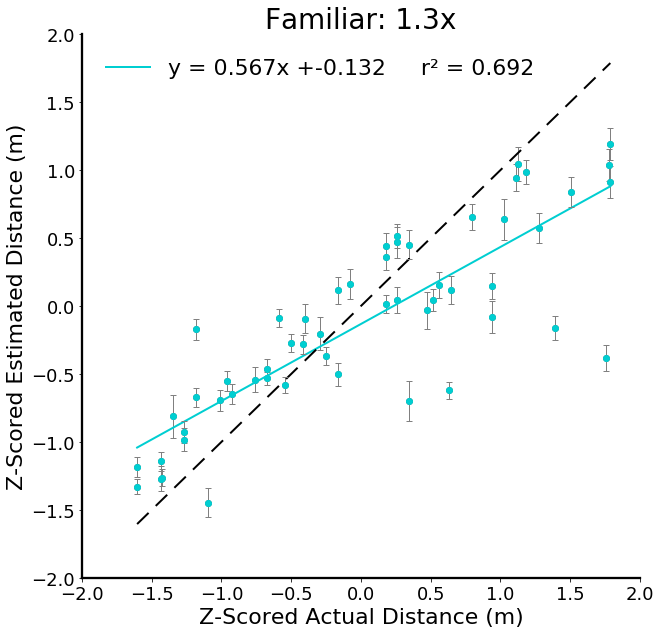

In [39]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

X = np.array(fS_results_13x['actual_depth']).reshape(-1,1)
y = fS_results_13x['y']
ste = fS_results_13x['ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Familiar: 1.3x", fontsize = 28)

if col == 'zs_depth_estimates':
    plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.xlabel("Actual Distance (m)", fontsize = 22)
    plt.ylabel("Estimated Distance (m)", fontsize = 22)


dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkturquoise", mec = "darkturquoise", capsize = 3)

if col == 'zs_depth_estimates':
    plt.ylim(-2,2)
    plt.xlim(-2,2)

    plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
    plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)
else:
    plt.xticks(fontsize=18)
    plt.ylim(0, 9)
    plt.yticks(np.arange(0, 9, 1), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


# Save results to a dictionary
fS_results_13x['intercept'] = reg.intercept_
fS_results_13x['slope'] = reg.coef_[0]
fS_results_13x['r2'] = r2_score(y, y_predicted)
fS_results_13x['residuals'] = copy.deepcopy(y - y_predicted)

##### Object Mask

In [63]:
pearsonr(oM_results_75x['actual_depth'], oM_results_75x['y'])

(0.8836908400445861, 8.90293908838628e-19)

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Attempting to set identical bottom == top == 2 results in singular transformations; automatically expanding.


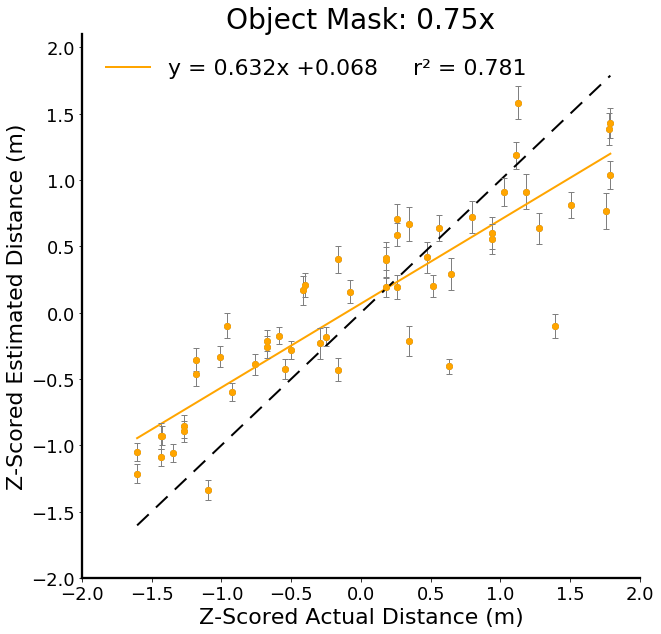

In [40]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

X = np.array(oM_results_75x['actual_depth']).reshape(-1,1)
y = oM_results_75x['y']
ste = oM_results_75x['ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Object Mask: 0.75x", fontsize = 28)

if col == 'zs_depth_estimates':
    plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.xlabel("Actual Distance (m)", fontsize = 22)
    plt.ylabel("Estimated Distance (m)", fontsize = 22)


dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "orange", mec = "orange", capsize = 3)

if col == 'zs_depth_estimates':
    plt.ylim(2,2)
    plt.xlim(-2,2)

    plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
    plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)
else:
    plt.xticks(fontsize=18)
    plt.ylim(0, 9)
    plt.yticks(np.arange(0, 9, 1), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


# Save results to a dictionary
oM_results_75x['intercept'] = reg.intercept_
oM_results_75x['slope'] = reg.coef_[0]
oM_results_75x['r2'] = r2_score(y, y_predicted)
oM_results_75x['residuals'] = copy.deepcopy(y - y_predicted)

In [64]:
pearsonr(oM_results_1x['actual_depth'], oM_results_1x['y'])

(0.8866461466554122, 4.734056539315166e-19)

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Attempting to set identical bottom == top == 2 results in singular transformations; automatically expanding.


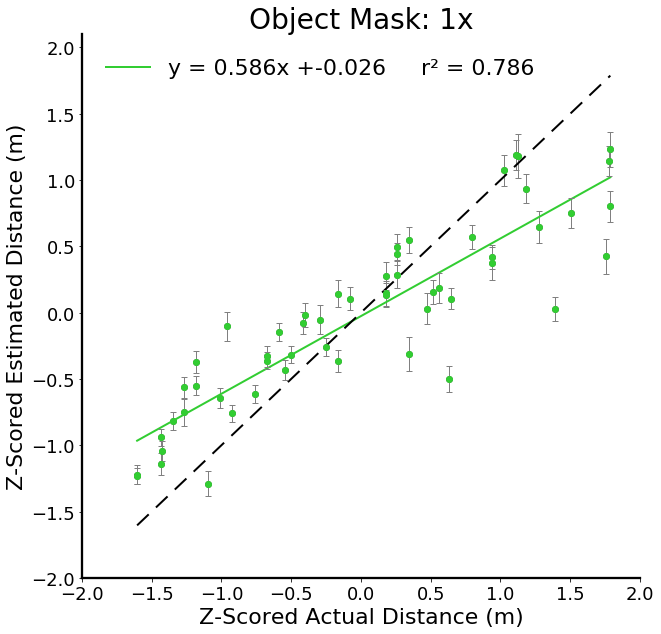

In [41]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

X = np.array(oM_results_1x['actual_depth']).reshape(-1,1)
y = oM_results_1x['y']
ste = oM_results_1x['ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Object Mask: 1x", fontsize = 28)

if col == 'zs_depth_estimates':
    plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.xlabel("Actual Distance (m)", fontsize = 22)
    plt.ylabel("Estimated Distance (m)", fontsize = 22)


dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "limegreen", mec = "limegreen", capsize = 3)

if col == 'zs_depth_estimates':
    plt.ylim(2,2)
    plt.xlim(-2,2)

    plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
    plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)
else:
    plt.xticks(fontsize=18)
    plt.ylim(0, 9)
    plt.yticks(np.arange(0, 9, 1), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


# Save results to a dictionary
oM_results_1x['intercept'] = reg.intercept_
oM_results_1x['slope'] = reg.coef_[0]
oM_results_1x['r2'] = r2_score(y, y_predicted)
oM_results_1x['residuals'] = copy.deepcopy(y - y_predicted)

In [65]:
pearsonr(oM_results_13x['actual_depth'], oM_results_13x['y'])

(0.8831212868700435, 1.00356342957859e-18)

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Attempting to set identical bottom == top == 2 results in singular transformations; automatically expanding.


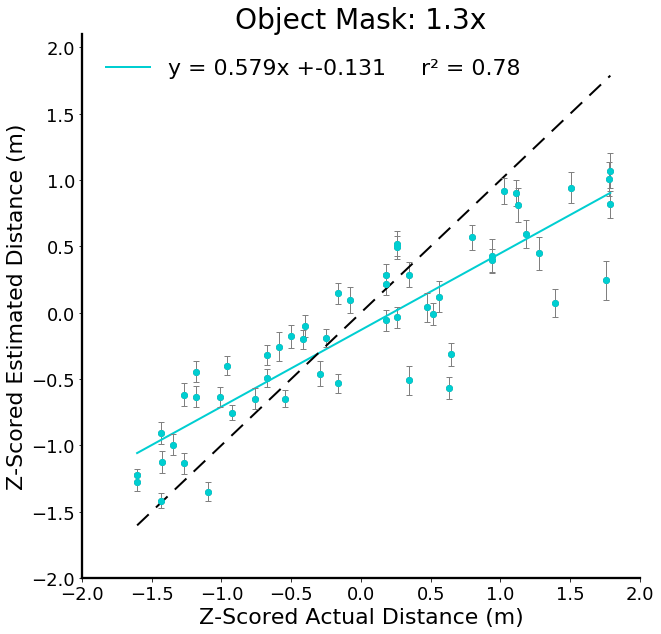

In [42]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

X = np.array(oM_results_13x['actual_depth']).reshape(-1,1)
y = oM_results_13x['y']
ste = oM_results_13x['ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Object Mask: 1.3x", fontsize = 28)

if col == 'zs_depth_estimates':
    plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
    plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

else:
    plt.xlabel("Actual Distance (m)", fontsize = 22)
    plt.ylabel("Estimated Distance (m)", fontsize = 22)


dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkturquoise", mec = "darkturquoise", capsize = 3)

if col == 'zs_depth_estimates':
    plt.ylim(2,2)
    plt.xlim(-2,2)

    plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
    plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)
else:
    plt.xticks(fontsize=18)
    plt.ylim(0, 9)
    plt.yticks(np.arange(0, 9, 1), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


# Save results to a dictionary
oM_results_13x['intercept'] = reg.intercept_
oM_results_13x['slope'] = reg.coef_[0]
oM_results_13x['r2'] = r2_score(y, y_predicted)
oM_results_13x['residuals'] = copy.deepcopy(y - y_predicted)

In [53]:
results_path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/data/results/'

In [55]:
import pickle
# Exporting to a pickle file
with open(results_path + '250_fS_0.75x.pkl', 'wb') as pickle_file:
    pickle.dump(fS_results_75x, pickle_file)

with open(results_path + '250_fS_1x.pkl', 'wb') as pickle_file:
    pickle.dump(fS_results_1x, pickle_file)

with open(results_path + '250_fS_1.3x.pkl', 'wb') as pickle_file:
    pickle.dump(fS_results_13x, pickle_file)


with open(results_path + '250_oM_0.75x.pkl', 'wb') as pickle_file:
    pickle.dump(oM_results_75x, pickle_file)

with open(results_path + '250_oM_1x.pkl', 'wb') as pickle_file:
    pickle.dump(oM_results_1x, pickle_file)

with open(results_path + '250_oM_1.3x.pkl', 'wb') as pickle_file:
    pickle.dump(oM_results_13x, pickle_file)

### Plot obj mask x familiar against each other

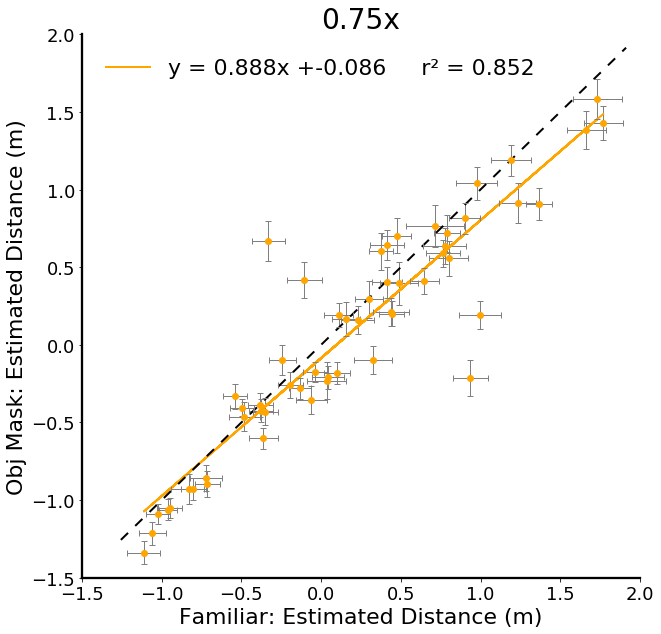

In [63]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_75x['y']).reshape(-1,1)
y = oM_results_75x['y']
ste_x = fS_results_75x['ste']
ste_y = oM_results_75x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)


plt.title("0.75x", fontsize = 28)
plt.xlabel("Familiar: Estimated Distance (m)", fontsize = 22)
plt.ylabel("Obj Mask: Estimated Distance (m)", fontsize = 22)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-1.5,2)
plt.xlim(-1.5,2)

plt.xticks(np.arange(-1.5, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-1.5, 2.5, 0.5), fontsize=18)

plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "orange", mec = "orange", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


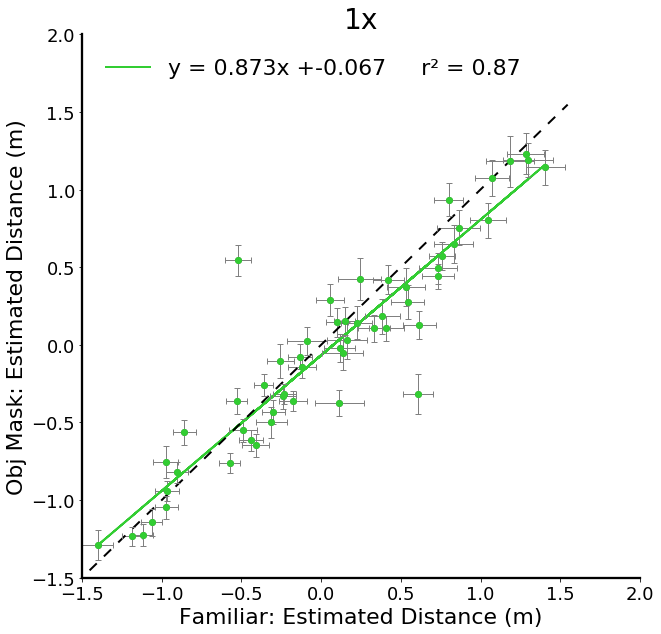

In [64]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_1x['y']).reshape(-1,1)
y = oM_results_1x['y']
ste_x = fS_results_1x['ste']
ste_y = oM_results_1x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("1x", fontsize = 28)

plt.xlabel("Familiar: Estimated Distance (m)", fontsize = 22)
plt.ylabel("Obj Mask: Estimated Distance (m)", fontsize = 22)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-1.5,2)
plt.xlim(-1.5,2)

plt.xticks(np.arange(-1.5, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-1.5, 2.5, 0.5), fontsize=18)
plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "limegreen", mec = "limegreen", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

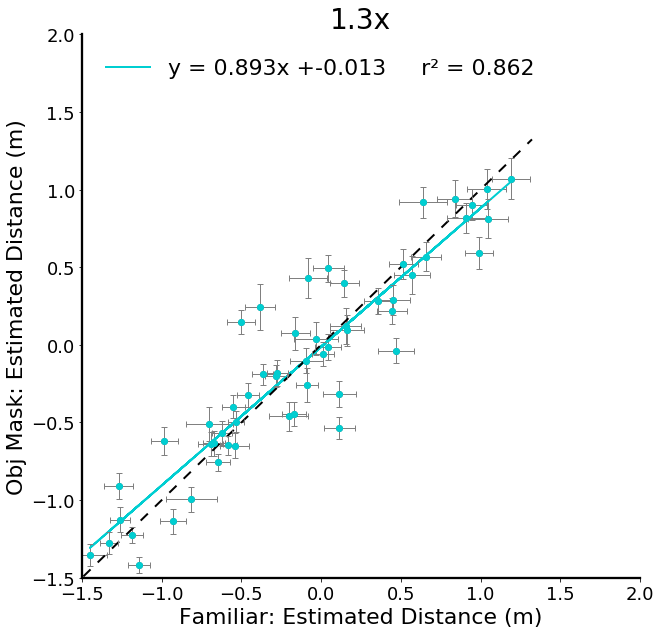

In [65]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_13x['y']).reshape(-1,1)
y = oM_results_13x['y']
ste_x = fS_results_13x['ste']
ste_y = oM_results_13x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("1.3x", fontsize = 28)

plt.xlabel("Familiar: Estimated Distance (m)", fontsize = 22)
plt.ylabel("Obj Mask: Estimated Distance (m)", fontsize = 22)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-1.5,2)
plt.xlim(-1.5,2)

plt.xticks(np.arange(-1.5, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-1.5, 2.5, 0.5), fontsize=18)

plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkturquoise", mec = "darkturquoise", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

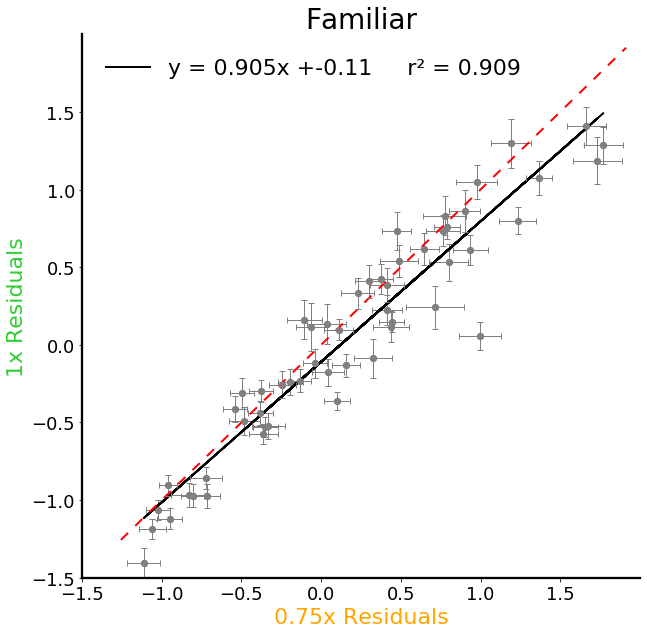

In [66]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_75x['y']).reshape(-1,1)
y = fS_results_1x['y']
ste_x = fS_results_75x['ste']
ste_y = fS_results_1x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='black', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

plt.title("Familiar", fontsize = 28)

plt.xlabel("0.75x Residuals", fontsize = 22, color='orange')
plt.ylabel("1x Residuals", fontsize = 22, color='limegreen')

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='red', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-1.5,2)
plt.xlim(-1.5,2)

plt.xticks(np.arange(-1.5, 2, 0.5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, 0.5), fontsize=18)

plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "gray", mec = "gray", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

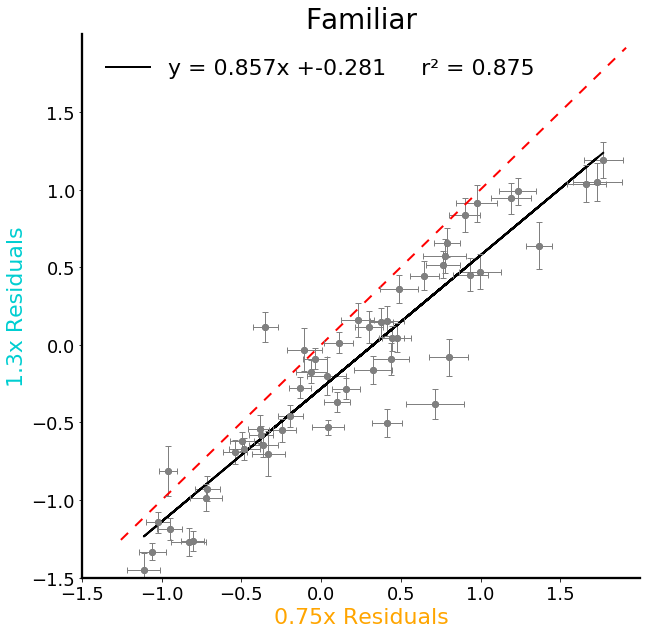

In [67]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_75x['y']).reshape(-1,1)
y = fS_results_13x['y']
ste_x = fS_results_75x['ste']
ste_y = fS_results_13x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='black', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

plt.title("Familiar", fontsize = 28)

plt.xlabel("0.75x Residuals", fontsize = 22, color='orange')
plt.ylabel("1.3x Residuals", fontsize = 22, color='darkturquoise')

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='red', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-1.5,2)
plt.xlim(-1.5,2)

plt.xticks(np.arange(-1.5, 2, 0.5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, 0.5), fontsize=18)

plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "gray", mec = "gray", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

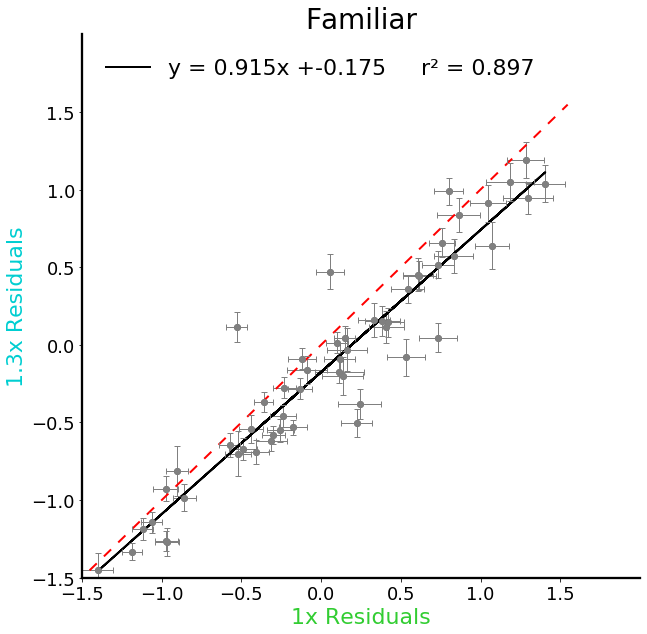

In [68]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_1x['y']).reshape(-1,1)
y = fS_results_13x['y']
ste_x = fS_results_1x['ste']
ste_y = fS_results_13x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='black', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

plt.title("Familiar", fontsize = 28)

plt.xlabel("1x Residuals", fontsize = 22, color='limegreen')
plt.ylabel("1.3x Residuals", fontsize = 22, color='darkturquoise')

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='red', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-1.5,2)
plt.xlim(-1.5,2)

plt.xticks(np.arange(-1.5, 2, 0.5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, 0.5), fontsize=18)

plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "gray", mec = "gray", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

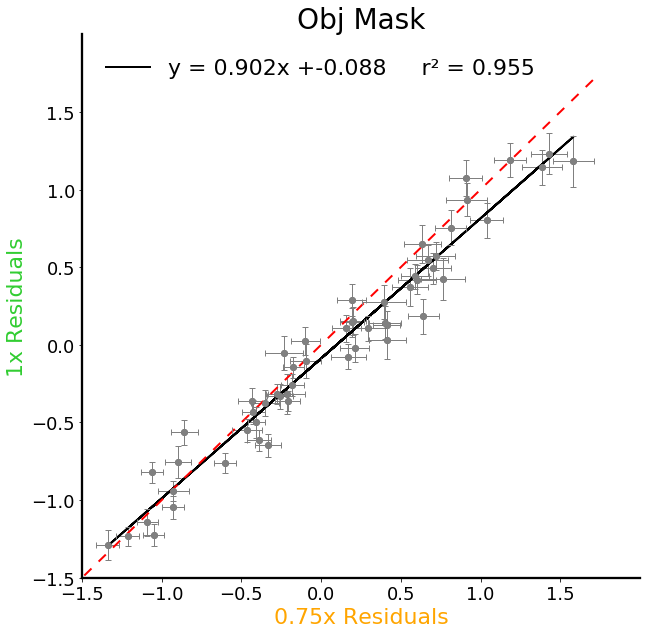

In [69]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(oM_results_75x['y']).reshape(-1,1)
y = oM_results_1x['y']
ste_x = oM_results_75x['ste']
ste_y = oM_results_1x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='black', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

plt.title("Obj Mask", fontsize = 28)

plt.xlabel("0.75x Residuals", fontsize = 22, color='orange')
plt.ylabel("1x Residuals", fontsize = 22, color='limegreen')

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='red', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-1.5,2)
plt.xlim(-1.5,2)

plt.xticks(np.arange(-1.5, 2, 0.5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, 0.5), fontsize=18)

plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "gray", mec = "gray", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

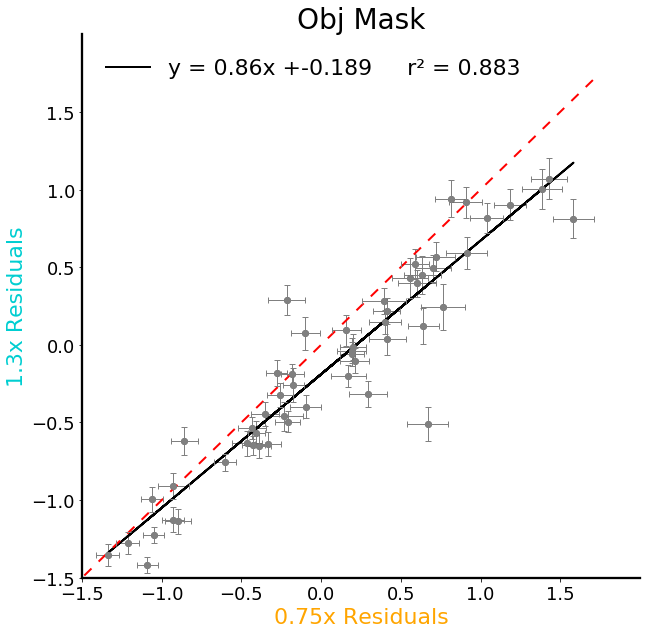

In [70]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(oM_results_75x['y']).reshape(-1,1)
y = oM_results_13x['y']
ste_x = oM_results_75x['ste']
ste_y = oM_results_13x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='black', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

plt.title("Obj Mask", fontsize = 28)

plt.xlabel("0.75x Residuals", fontsize = 22, color='orange')
plt.ylabel("1.3x Residuals", fontsize = 22, color='darkturquoise')

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='red', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-1.5,2)
plt.xlim(-1.5,2)

plt.xticks(np.arange(-1.5, 2, 0.5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, 0.5), fontsize=18)

plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "gray", mec = "gray", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

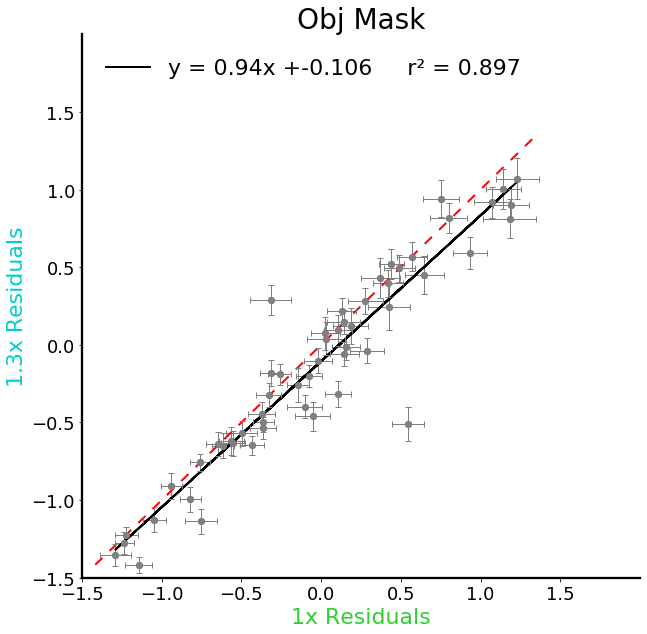

In [71]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(oM_results_1x['y']).reshape(-1,1)
y = oM_results_13x['y']
ste_x = oM_results_1x['ste']
ste_y = oM_results_13x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='black', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

plt.title("Obj Mask", fontsize = 28)

plt.xlabel("1x Residuals", fontsize = 22, color='limegreen')
plt.ylabel("1.3x Residuals", fontsize = 22, color='darkturquoise')

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='red', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-1.5,2)
plt.xlim(-1.5,2)

plt.xticks(np.arange(-1.5, 2, 0.5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, 0.5), fontsize=18)

plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "gray", mec = "gray", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

### Plot Residuals 

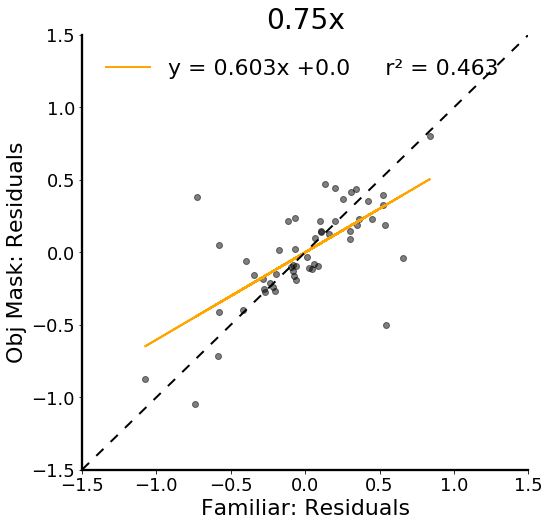

In [72]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_75x['residuals']).reshape(-1,1)
y = oM_results_75x['residuals']
# ste_x = fS_results_75x['ste']
# ste_y = oM_results_75x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("0.75x", fontsize = 28)

plt.xlabel("Familiar: Residuals", fontsize = 22)
plt.ylabel("Obj Mask: Residuals", fontsize = 22)

plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xticks(np.arange(-1.5, 2, .5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, .5), fontsize=18)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

# plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "orange", mec = "orange", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


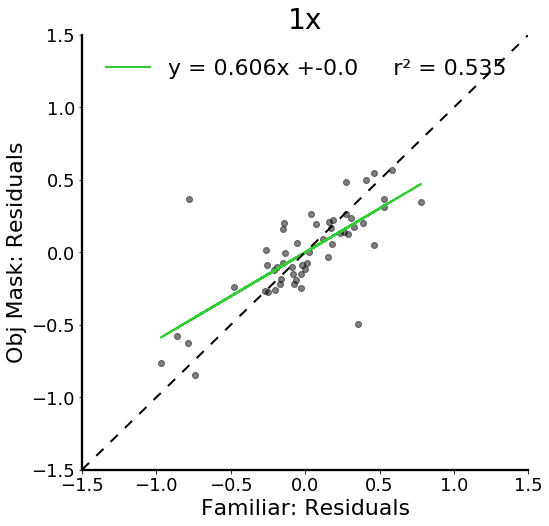

In [73]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_1x['residuals']).reshape(-1,1)
y = oM_results_1x['residuals']
# ste_x = fS_results_1x['ste']
# ste_y = oM_results_1x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("1x", fontsize = 28)

plt.xlabel("Familiar: Residuals", fontsize = 22)
plt.ylabel("Obj Mask: Residuals", fontsize = 22)

plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xticks(np.arange(-1.5, 2, .5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, .5), fontsize=18)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

# plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "limegreen", mec = "limegreen", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)



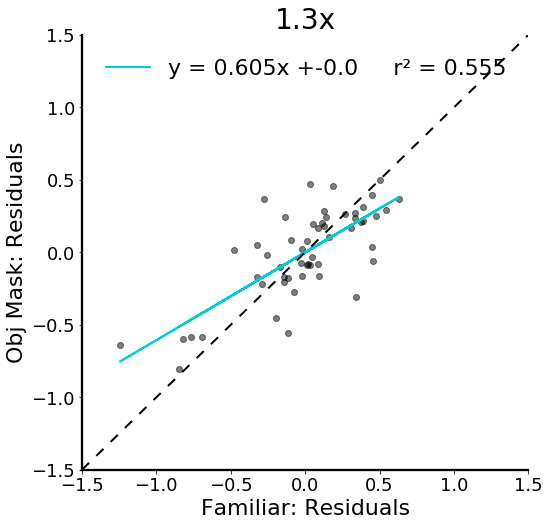

In [74]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_13x['residuals']).reshape(-1,1)
y = oM_results_13x['residuals']
# ste_x = fS_results_13x['ste']
# ste_y = oM_results_13x['ste']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("1.3x", fontsize = 28)

plt.xlabel("Familiar: Residuals", fontsize = 22)
plt.ylabel("Obj Mask: Residuals", fontsize = 22)

plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xticks(np.arange(-1.5, 2, .5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, .5), fontsize=18)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

# plt.errorbar(X, y, yerr=ste_y, xerr=ste_x, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkturquoise", mec = "darkturquoise", capsize = 3)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)



In [75]:
fS_avg_resid_75x = np.mean(np.abs(np.array(fS_results_75x['residuals'])))
oM_avg_resid_75x = np.mean(np.abs(np.array(oM_results_75x['residuals'])))

# fS_sem_resid_75x = stats.sem(np.array(fS_results_75x['residuals']))
# oM_sem_resid_75x = stats.sem(np.array(oM_results_75x['residuals']))


fS_sem_resid_75x = stats.sem(np.abs(np.array(fS_results_75x['residuals'])))
oM_sem_resid_75x = stats.sem(np.abs(np.array(oM_results_75x['residuals'])))



fS_avg_resid_1x = np.mean(np.abs(np.array(fS_results_1x['residuals'])))
oM_avg_resid_1x = np.mean(np.abs(np.array(oM_results_1x['residuals'])))

# fS_sem_resid_1x = stats.sem(np.array(fS_results_1x['residuals']))
# oM_sem_resid_1x = stats.sem(np.array(oM_results_1x['residuals']))

fS_sem_resid_1x = stats.sem(np.abs(np.array(fS_results_1x['residuals'])))
oM_sem_resid_1x = stats.sem(np.abs(np.array(oM_results_1x['residuals'])))



fS_avg_resid_13x = np.mean(np.abs(np.array(fS_results_13x['residuals'])))
oM_avg_resid_13x = np.mean(np.abs(np.array(oM_results_13x['residuals'])))

# fS_sem_resid_13x = stats.sem(np.array(fS_results_13x['residuals']))
# oM_sem_resid_13x = stats.sem(np.array(oM_results_13x['residuals']))

fS_sem_resid_13x = stats.sem(np.abs(np.array(fS_results_13x['residuals'])))
oM_sem_resid_13x = stats.sem(np.abs(np.array(oM_results_13x['residuals'])))

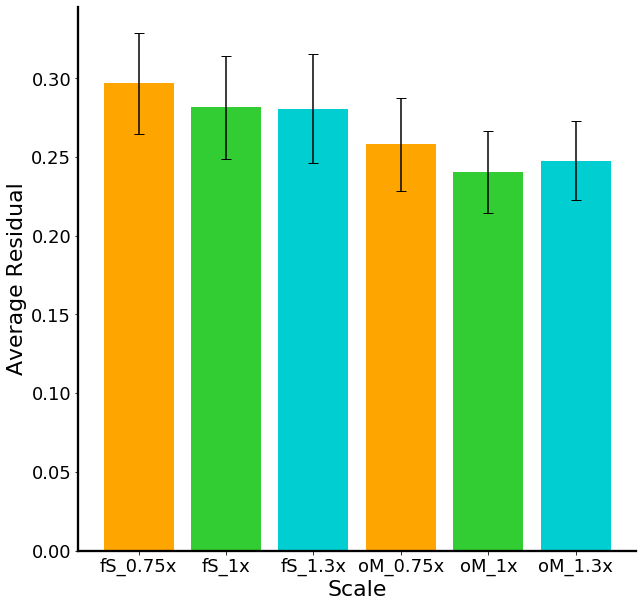

In [76]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
scales = ['fS_0.75x', 'fS_1x','fS_1.3x','oM_0.75x', 'oM_1x', 'oM_1.3x']
averages_resid = np.array([fS_avg_resid_75x, fS_avg_resid_1x, fS_avg_resid_13x, oM_avg_resid_75x, oM_avg_resid_1x, oM_avg_resid_13x])
sem_resid = [fS_sem_resid_75x, fS_sem_resid_1x, fS_sem_resid_13x, oM_sem_resid_75x, oM_sem_resid_1x, oM_sem_resid_13x]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
plt.ylabel("Average Residual", fontsize = 22)

    
# plt.yticks(np.arange(-0.20,0.25, 0.05))

plt.bar(scales, averages_resid, yerr=sem_resid, color = ['orange', 'limegreen', 'darkturquoise', 'orange', 'limegreen', 'darkturquoise'], width=0.8, capsize=5)


plt.show()

In [77]:
print('       fS_0.75x', '              fS_1x','                   fS_1.3x','                oM_0.75x', '           oM_1x', '           oM_1.3x')
print(averages_resid)
print(sem_resid)

       fS_0.75x               fS_1x                    fS_1.3x                 oM_0.75x            oM_1x            oM_1.3x
[0.29677391 0.28152163 0.28083651 0.25799928 0.24043244 0.24762033]
[0.03217449478278904, 0.03276733612726241, 0.03484682577671504, 0.029352721879596533, 0.025881541053759855, 0.025018220032399254]


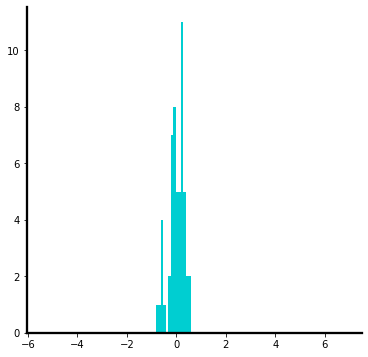

(-0.8054304381684019, 0.49872679274693466)

In [78]:
fig, ax = plt.subplots(figsize=[6,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
# Choose a bin width
bin_width = .1 # Adjust this value as needed for your data

# Create bins
bins = np.arange(global_min, global_max + bin_width, bin_width)

# plt.hist(np.array(oM_results_75x['residuals']), bins=bins, color='orange')
# plt.hist(np.array(oM_results_1x['residuals']), bins=bins, color='limegreen')
plt.hist(np.array(oM_results_13x['residuals']), bins=bins, color='darkturquoise')
plt.show()


min(np.array(oM_results_13x['residuals'])), max(np.array(oM_results_13x['residuals']))

### Residual plots: Within task across scale

##### Familiar

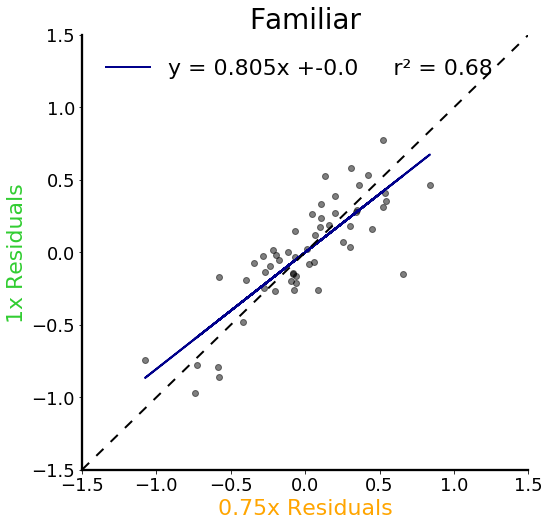

In [79]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_75x['residuals']).reshape(-1,1)
y = fS_results_1x['residuals']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkblue', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Familiar", fontsize = 28)

plt.xlabel("0.75x Residuals", fontsize = 22, color='orange')
plt.ylabel("1x Residuals", fontsize = 22, color='limegreen')

plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xticks(np.arange(-1.5, 2, .5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, .5), fontsize=18)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)


legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

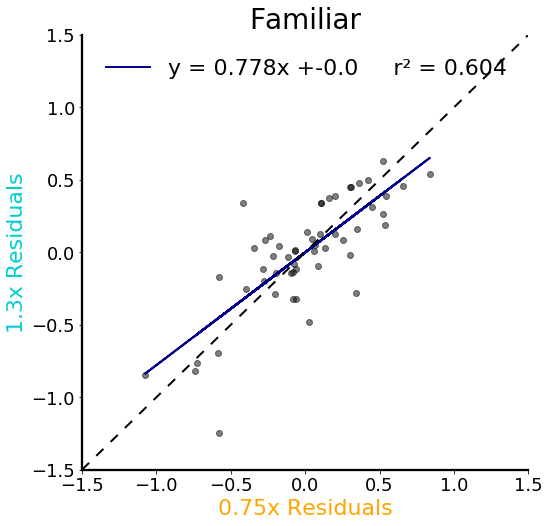

In [80]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_75x['residuals']).reshape(-1,1)
y = fS_results_13x['residuals']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkblue', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Familiar", fontsize = 28)

plt.xlabel("0.75x Residuals", fontsize = 22, color='orange')
plt.ylabel("1.3x Residuals", fontsize = 22, color='darkturquoise')


plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xticks(np.arange(-1.5, 2, .5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, .5), fontsize=18)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

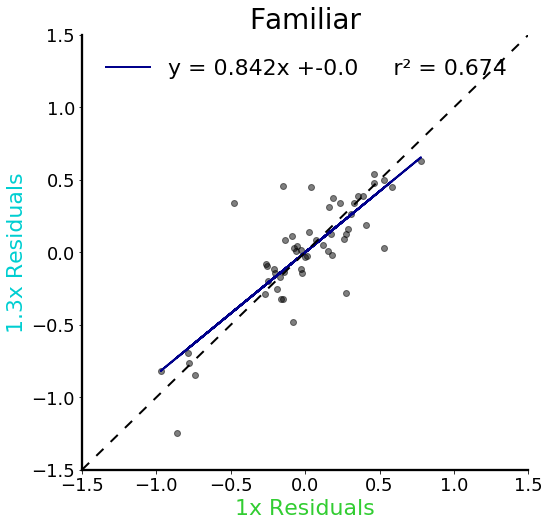

In [81]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(fS_results_1x['residuals']).reshape(-1,1)
y = fS_results_13x['residuals']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkblue', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Familiar", fontsize = 28)

plt.xlabel("1x Residuals", fontsize = 22, color='limegreen')
plt.ylabel("1.3x Residuals", fontsize = 22, color='darkturquoise')

plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xticks(np.arange(-1.5, 2, .5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, .5), fontsize=18)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

##### Object Mask

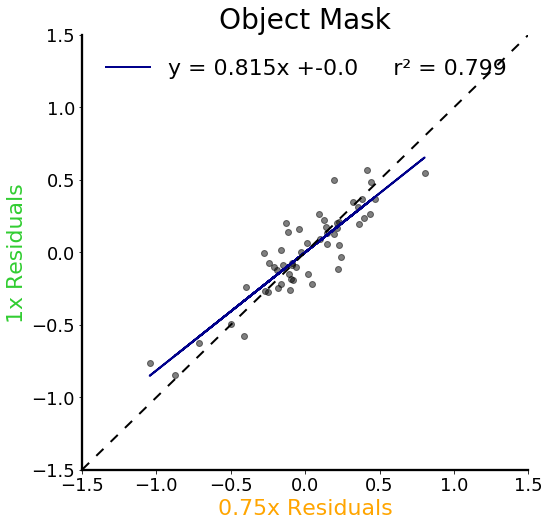

In [82]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(oM_results_75x['residuals']).reshape(-1,1)
y = oM_results_1x['residuals']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkblue', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Object Mask", fontsize = 28)

plt.xlabel("0.75x Residuals", fontsize = 22, color='orange')
plt.ylabel("1x Residuals", fontsize = 22, color='limegreen')

plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xticks(np.arange(-1.5, 2, .5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, .5), fontsize=18)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

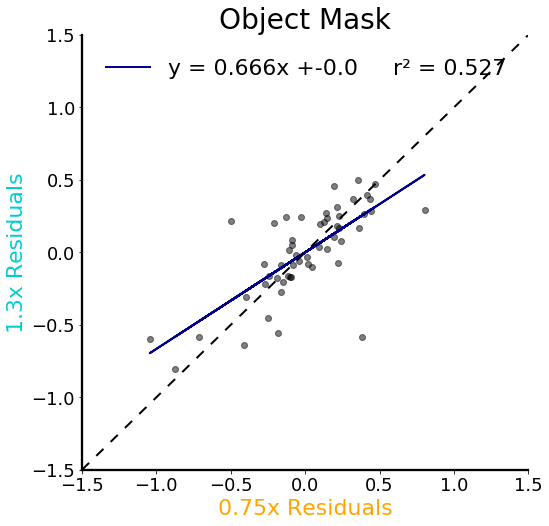

In [83]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(oM_results_75x['residuals']).reshape(-1,1)
y = oM_results_13x['residuals']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkblue', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Object Mask", fontsize = 28)

plt.xlabel("0.75x Residuals", fontsize = 22, color='orange')
plt.ylabel("1.3x Residuals", fontsize = 22, color='darkturquoise')

plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xticks(np.arange(-1.5, 2, .5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, .5), fontsize=18)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

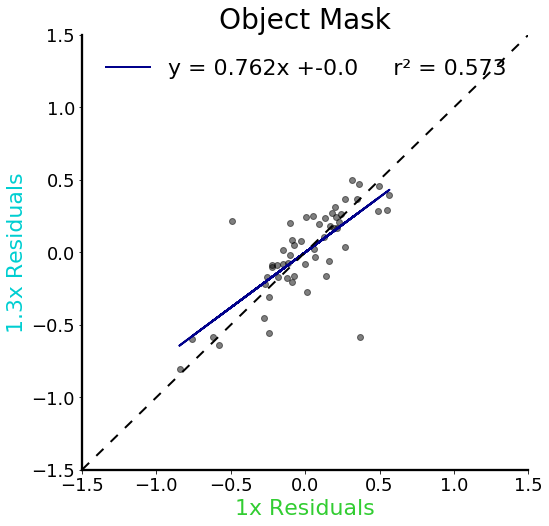

In [84]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(oM_results_1x['residuals']).reshape(-1,1)
y = oM_results_13x['residuals']

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='darkblue', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Object Mask", fontsize = 28)

plt.xlabel("1x Residuals", fontsize = 22, color='limegreen')
plt.ylabel("1.3x Residuals", fontsize = 22, color='darkturquoise')


plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xticks(np.arange(-1.5, 2, .5), fontsize=18)
plt.yticks(np.arange(-1.5, 2, .5), fontsize=18)

# Define the start and end points based on the plot's limits
start, end = plt.xlim()
dash_pattern = [5, 5]
# Plot the line using the start and end points
plt.plot([start, end], [start, end], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

## Matrices

In [85]:
fS_results_1x.keys()

dict_keys(['stimuli', 'y', 'ste', 'x', 'std', 'RT', 'RT_ste', 'actual_depth', 'intercept', 'slope', 'r2', 'residuals'])

In [86]:
NE_data = {'fS_75x': fS_results_75x['y'],
    'fS_1x': fS_results_1x['y'],
    'fS_13x': fS_results_13x['y'],
    'oM_75x': oM_results_75x['y'],
    'oM_1x': oM_results_1x['y'],
    'oM_13x': oM_results_13x['y']
    }

NE_df = pd.DataFrame(NE_data,columns=list(NE_data.keys()))

NE_df_corr = NE_df.corr()

In [87]:
NE_df_corr

,fS_75x,fS_1x,fS_13x,oM_75x,oM_1x,oM_13x
fS_75x,1.000000,0.953266,0.935564,0.922856,0.928901,0.951085
fS_1x,0.953266,1.000000,0.947340,0.934482,0.932706,0.966453
fS_13x,0.935564,0.947340,1.000000,0.883156,0.904036,0.928582
oM_75x,0.922856,0.934482,0.883156,1.000000,0.976990,0.939796
oM_1x,0.928901,0.932706,0.904036,0.976990,1.000000,0.947214
oM_13x,0.951085,0.966453,0.928582,0.939796,0.947214,1.000000


<Figure size 1080x1080 with 0 Axes>

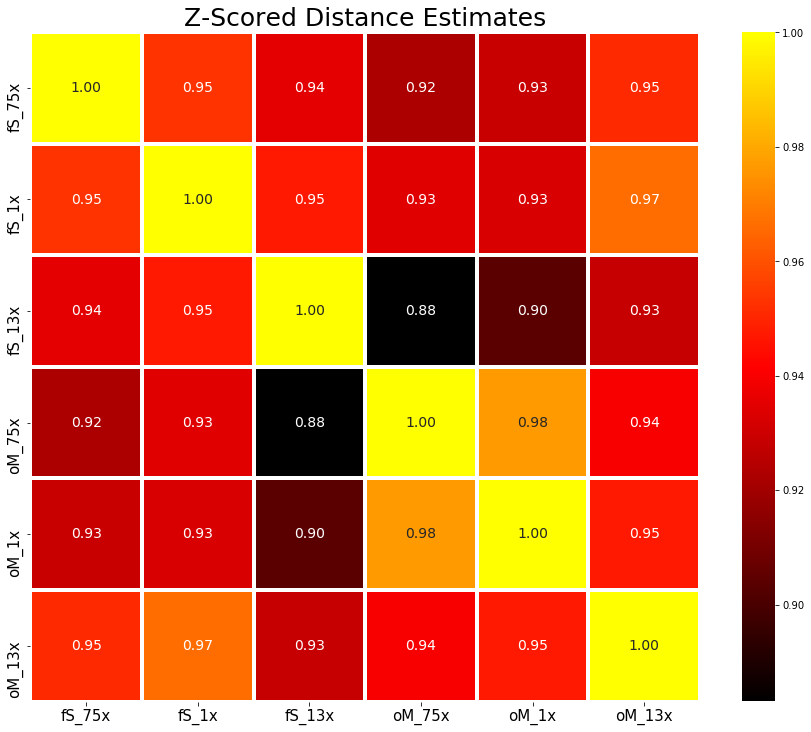

In [89]:
import seaborn as sns
import matplotlib.colors
import matplotlib.colors as mcolors


plt.figure(figsize=[15,15])

# Custom colormap from black to yellow
colors = ["black", "red", "yellow"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Normalize the color mapping to start at 0.5 instead of 0
norm = mcolors.Normalize(vmin=0.5, vmax=1)

plt.figure(figsize=[15,15])

# Create the heatmap with normalization
ax = sns.heatmap(NE_df_corr, annot=True, fmt=".2f", cmap=cmap, norm=norm, square=True, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={"size": 14})

# Adjust the axis limits if necessary
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust font size here

if col == 'zs_depth_estimates':
    plt.title('Z-Scored Distance Estimates', fontsize=25)
else:
    plt.title('Distances Estimates', fontsize=25)

plt.savefig(fig_destination + '/rawMatrix-250-estimates.png', dpi=300)

plt.show();

In [90]:
NE_resid = {'fS_75x': fS_results_75x['residuals'],
    'fS_1x': fS_results_1x['residuals'],
    'fS_13x': fS_results_13x['residuals'],
    'oM_75x': oM_results_75x['residuals'],
    'oM_1x': oM_results_1x['residuals'],
    'oM_13x': oM_results_13x['residuals']
    }

NE_resid_df = pd.DataFrame(NE_resid,columns=list(NE_resid.keys()))

NE_resid_df_corr = NE_resid_df.corr()

<Figure size 1080x1080 with 0 Axes>

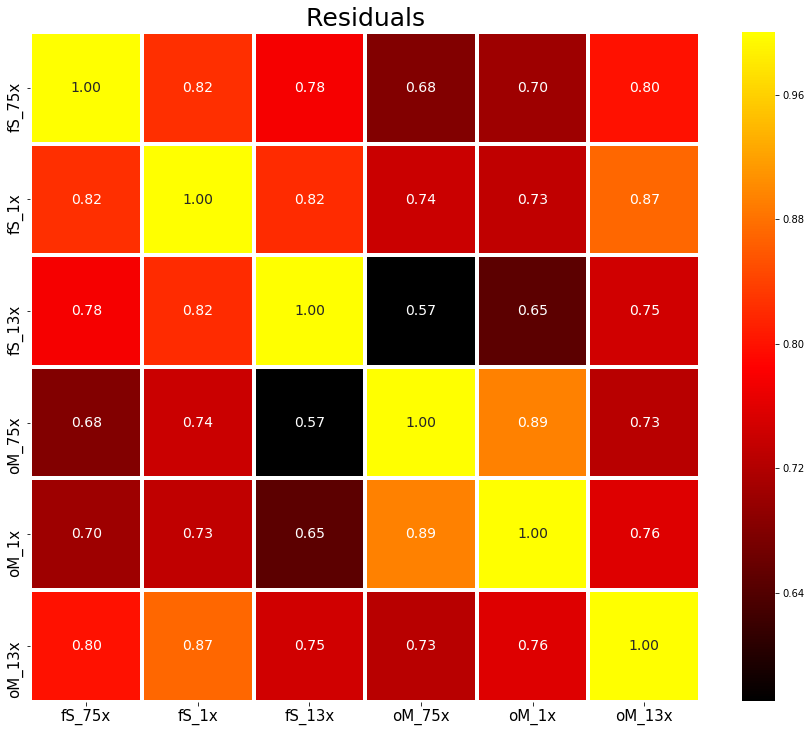

In [91]:
import seaborn as sns
import matplotlib.colors
import matplotlib.colors as mcolors


plt.figure(figsize=[15,15])

# Custom colormap from black to yellow
colors = ["black", "red", "yellow"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Normalize the color mapping to start at 0.5 instead of 0
norm = mcolors.Normalize(vmin=0.5, vmax=1)

plt.figure(figsize=[15,15])

# Create the heatmap with normalization
ax = sns.heatmap(NE_resid_df_corr, annot=True, fmt=".2f", cmap=cmap, norm=norm, square=True, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={"size": 14})

# Adjust the axis limits if necessary
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust font size here

plt.title('Residuals', fontsize=25)

plt.savefig(fig_destination + '/rawMatrix-250-residuals.png', dpi=300)

plt.show();

In [92]:
RT_data = {'fS_75x': fS_results_75x['RT'],
    'fS_1x': fS_results_1x['RT'],
    'fS_13x': fS_results_13x['RT'],
    'oM_75x': oM_results_75x['RT'],
    'oM_1x': oM_results_1x['RT'],
    'oM_13x': oM_results_13x['RT']
    }

RT_df = pd.DataFrame(RT_data,columns=list(RT_data.keys()))

RT_df_corr = RT_df.corr()

<Figure size 1080x1080 with 0 Axes>

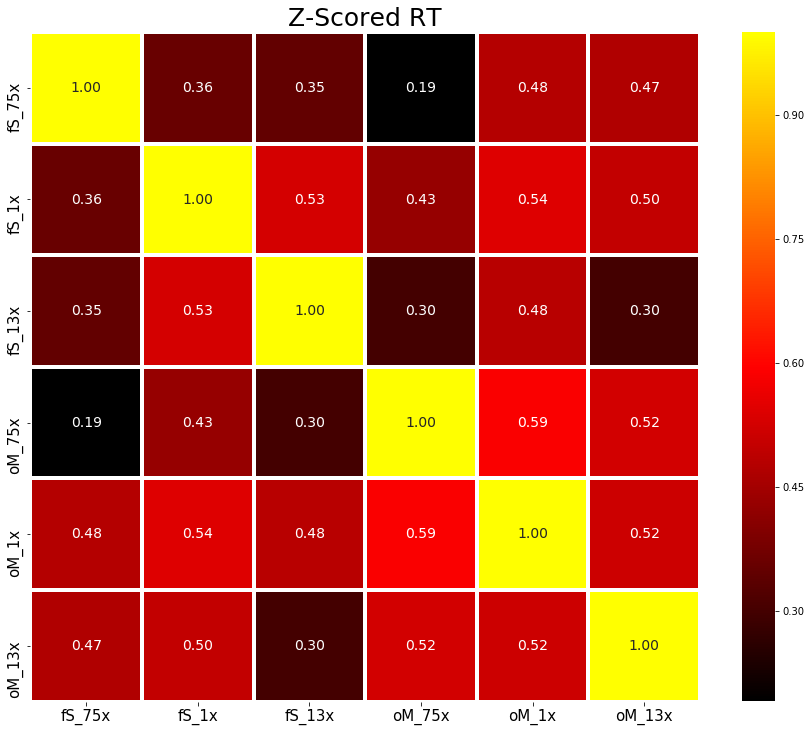

In [93]:
import seaborn as sns
import matplotlib.colors as mcolors


plt.figure(figsize=[15,15])

# Custom colormap from black to yellow
colors = ["black", "red", "yellow"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Normalize the color mapping to start at 0.5 instead of 0
norm = mcolors.Normalize(vmin=0.5, vmax=1)

plt.figure(figsize=[15,15])

# Create the heatmap with normalization
ax = sns.heatmap(RT_df_corr, annot=True, fmt=".2f", cmap=cmap, norm=norm, square=True, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={"size": 14})

# Adjust the axis limits if necessary
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust font size here


plt.title('Z-Scored RT', fontsize=25)

# plt.savefig('matrix_IES_5000.png')
# plt.savefig('/Users/pmahableshwarkar/Documents/Depth_Project/spatial_perception_SUNRGBD/joint_analyses/matrix_IES_5000.png')

plt.show();

In [94]:
outcomes_data = {'fS_75x_estim': fS_results_75x['y'],
                'fS_1x_estim': fS_results_1x['y'],
                'fS_13x_estim': fS_results_13x['y'],
                'oM_75x_estim': oM_results_75x['y'],
                'oM_1x_estim': oM_results_1x['y'],
                'oM_13x_estim': oM_results_13x['y'],
                'fS_75x_RT': fS_results_75x['RT'],
                'fS_1x_RT': fS_results_1x['RT'],
                'fS_13x_RT': fS_results_13x['RT'],
                'oM_75x_RT': oM_results_75x['RT'],
                'oM_1x_RT': oM_results_1x['RT'],
                'oM_13x_RT': oM_results_13x['RT']
                }

outcomes_df = pd.DataFrame(outcomes_data,columns=list(outcomes_data.keys()))

outcomes_df_corr = outcomes_df.corr()

<Figure size 1080x1080 with 0 Axes>

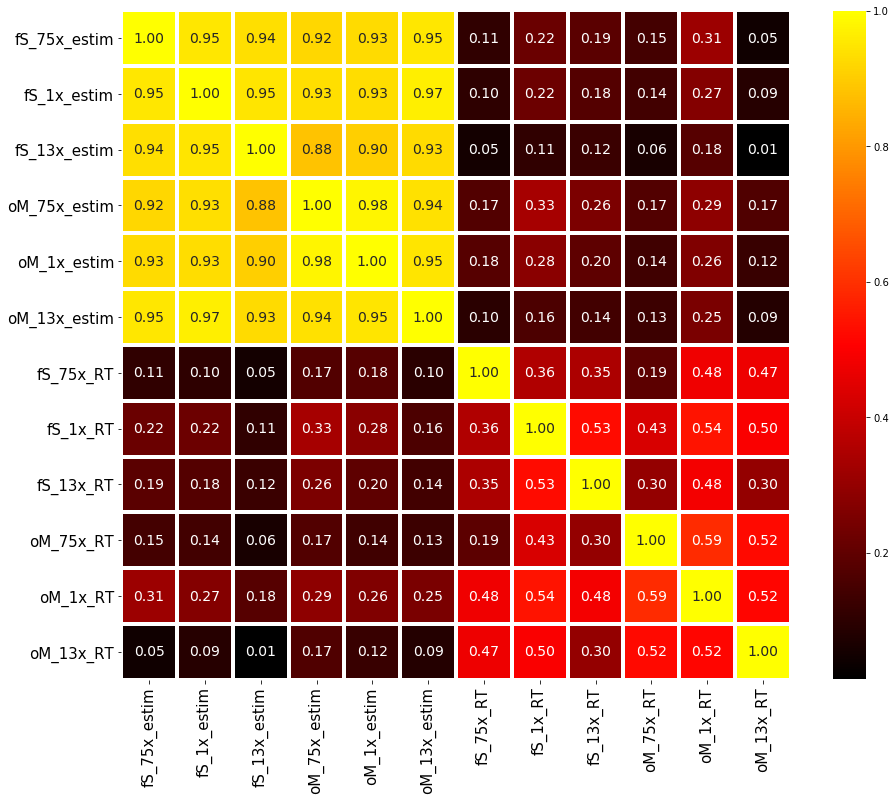

In [95]:
import seaborn as sns
import matplotlib.colors as mcolors


plt.figure(figsize=[15,15])

# Custom colormap from black to yellow
colors = ["black", "red", "yellow"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Normalize the color mapping to start at 0.5 instead of 0
norm = mcolors.Normalize(vmin=0.5, vmax=1)

plt.figure(figsize=[15,15])

# Create the heatmap with normalization
ax = sns.heatmap(outcomes_df_corr, annot=True, fmt=".2f", cmap=cmap, norm=norm, square=True, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={"size": 14})

# Adjust the axis limits if necessary
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust font size here


plt.title('', fontsize=25)

plt.show();

## Plot from R (LME) Output

In [105]:
dp = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/data/250ms_LME_interaction.csv'
lme_interaction_df = pd.read_csv(dp)
lme_interaction_df

,scale,condition,emmean,SE,df,lower.CL,upper.CL,upper,lower
0,canonical,BC,-0.010524,0.107241,41.083189,-0.227088,0.206041,0.096717,-0.117765
1,large,BC,-0.114325,0.107240,41.081936,-0.330888,0.102238,-0.007085,-0.221565
2,small,BC,0.084977,0.107240,41.081409,-0.131585,0.301539,0.192217,-0.022263
3,canonical,FS,0.064409,0.107245,41.089752,-0.152163,0.280981,0.171654,-0.042836
4,large,FS,-0.114696,0.107245,41.090017,-0.331269,0.101876,-0.007451,-0.221942
5,small,FS,0.190541,0.107250,41.097757,-0.026040,0.407122,0.297791,0.083290


In [106]:
order = [5, 6, 4, 2, 3, 1] 

lme_interaction_df['plotting_order'] = order

lme_interaction_df_sorted = lme_interaction_df.sort_values(by='plotting_order', ascending=True)

lme_interaction_df_sorted

,scale,condition,emmean,SE,df,lower.CL,upper.CL,upper,lower,plotting_order
5,small,FS,0.190541,0.107250,41.097757,-0.026040,0.407122,0.297791,0.083290,1
3,canonical,FS,0.064409,0.107245,41.089752,-0.152163,0.280981,0.171654,-0.042836,2
4,large,FS,-0.114696,0.107245,41.090017,-0.331269,0.101876,-0.007451,-0.221942,3
2,small,BC,0.084977,0.107240,41.081409,-0.131585,0.301539,0.192217,-0.022263,4
0,canonical,BC,-0.010524,0.107241,41.083189,-0.227088,0.206041,0.096717,-0.117765,5
1,large,BC,-0.114325,0.107240,41.081936,-0.330888,0.102238,-0.007085,-0.221565,6


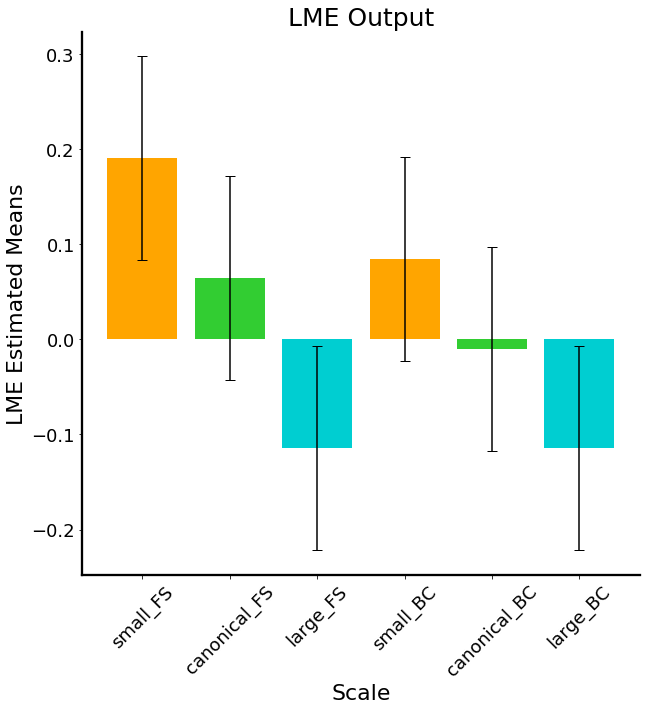

In [108]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
scales =  [a + '_' + b for a, b in zip(list(lme_interaction_df_sorted['scale']), list(lme_interaction_df_sorted['condition']))]
emmean = list(lme_interaction_df_sorted['emmean'])
errors = list(lme_interaction_df_sorted['SE'])

plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
plt.ylabel("LME Estimated Means", fontsize = 22)

    
# plt.yticks(np.arange(-0.20,0.25, 0.05))

plt.bar(scales, emmean, yerr = errors, color = ['orange', 'limegreen', 'darkturquoise', 'orange', 'limegreen', 'darkturquoise'], width=0.8, capsize=5)

plt.title('LME Output', fontsize=25)
plt.show()

## RT

In [72]:
trial_pivot = trial_pivotTable(MX_data, col, 'zs_trial_RT')

trial_final = trial_getxy(trial_pivot)

results_250 = {}

results_250['stimuli'] = trial_final[0]
results_250['y'] = trial_final[1]
results_250['ste'] = trial_final[2]
results_250['x'] = trial_final[3]
results_250['std'] = trial_final[4]
results_250['RT'] = trial_final[5]
results_250['RT_ste'] = trial_final[6]

results_250['actual_depth'] = (np.array(results_250['x']) - np.mean(np.array(results_250['x'])))/np.std(np.array(results_250['x']))

In [73]:
from scipy.stats import pearsonr
pearsonr(results_250['y'], results_250['RT'])

(0.18092179085508042, 0.0010715257468571315)

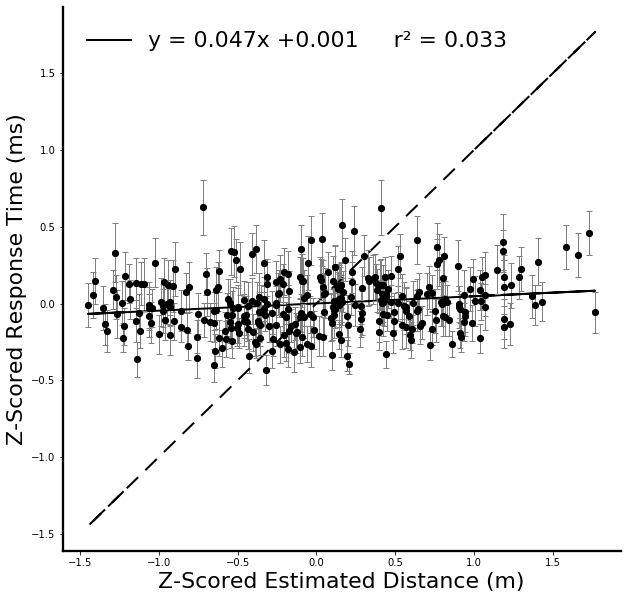

In [75]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(results_250['y']).reshape(-1,1)
y = results_250['RT']
ste = results_250['RT_ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='black', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

plt.xlabel("Z-Scored Estimated Distance (m)", fontsize = 22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)

dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "black", mec = "black", capsize = 3)

# plt.ylim(-2,2)
# plt.xlim(-2,2)

# plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
# plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)


legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)